# <center>$\color{Red} {SD \; - \; TSIA \: Data \: Challenge \: 2020}$</center> #

### <center>$\color{Blue} {MAAZOUN \: Imen \: \: , \: \: EL \: \: AOUD \: Syrine}$</center> ###

### overview of our approach ###

In this challenge, we are supposed to build a fusion of algorithms for face recognition. 
Given a dataset a label set of training data, each sample of which already computed from a couple of two images, we worked on creating a model that best decide whether two images belong to the same person or not. We considered the prediction accuracy on the test set as the performance criterion for this model. 

To achieve this goal, we proceeded as follow:
We start by investigating the data, then preprocess it,  then we will apply the various ML methods for classifications, and for each classifier we try to tune the hyperparameters to find the most adequate values, and we will also try voting between multiple classifiers.

For each method we try to define a tuning procedure, and using the results of confusion matrix, we conclude about the performance of the model.

Our data is highly skewed so we will use confusion matrix as it is easy to interpret and allow us to notice when our model gives particularly an important ratio of False Negatives or False Positives. 

Here is a summary of our work that was established progressively :

0- Loading Libraries and defining some useful functions

1- Loading, investigating and preprocessing the data


2- Applying feature selection using PCA

3- Naive Bayes Classifier

4- Linear Classifiers : 

    Logistic Regression 
    Linear SVM classifier
    

5- Neural Networks


6- Decision Trees

7- Random Forests

8- Boosting

9- Voting between different classifiers

Conclusion

$\color{Red} {**NB:** }$

**Along the whole report, we included comments over the obtained results. And also we put a detailed interpretation of the whole work in the conclusion** 


### 0. Loading Libraries and defining some useful functions ###

In [ ]:
%matplotlib inline
import sys
import os
import time
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.decomposition import PCA

# Split and crossvalidation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  cross_val_score, cross_validate, cross_val_predict, GridSearchCV, KFold , validation_curve

# Classifiers
from sklearn.linear_model import LogisticRegression, RidgeClassifier, RidgeClassifierCV, PassiveAggressiveClassifier, Perceptron, SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neural_network import MLPClassifier

# Ensemble methods 
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier,RandomForestClassifier, VotingClassifier

# Neural Networks
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers

# LightGBM 
import lightgbm as lgbm

#PostProcessing
from sklearn.metrics import classification_report, confusion_matrix


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

np.random.seed(42)

In [ ]:
print("Python : ", sys.version)
print("Tensorflow : ", tf.__version__)

Python :  3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
Tensorflow :  2.2.0-rc3


In [ ]:
def computeAcc(y_hat, labels):
    """
    This function computes the accuracy of predictions
      y_hat : predicted labels
      labels : true labes
    """
    accuracy = 0
    for i in range(y_hat.shape[0]):

      if  (y_hat[i] == labels[i]) :
        accuracy = accuracy + 1 
    accuracy = accuracy/labels.shape[0]  
    return accuracy

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]), 
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
  

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
def report(y_test, y_pred, total, classes, type="original"):
  """
    This function provides a report for the classification 
      y_test : true labes
      y_pred : predicted labels
      classes : list of unique labels
      type : type of the data considered for the classification training : original, scaled, ...
  """
  print("\nAccuracy with \033[1m" + type + " data \033[0;0m : ", computeAcc(y_pred, y_test))
  print("\nNumber of mislabeled points out of a total %d points : %d"% (total, (y_test != y_pred).sum()))
  cnf_matrix_gnb= confusion_matrix(y_test, y_pred)
  plt.figure()
  plot_confusion_matrix(cnf_matrix_gnb, classes, normalize=False)
  plt.show()

In [ ]:
def submission(clf, Xtest):
  """
    This function performs the classification on the testing set and saves the result in a csv file
      clf : classifer, already trained
      X_test : testing set features
  """
  ytest = clf.predict(Xtest)
  np.savetxt('ytest_challenge_student.csv', ytest, fmt = '%1.0d', delimiter=',')


# 1- Load and investigate the data




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Load training data
data_path = '/content/drive/My Drive/SD210 challenge/'
xtrain = np.loadtxt(data_path + 'xtrain_challenge.csv', delimiter=',', skiprows = 1)
ytrain = np.loadtxt(data_path + 'ytrain_challenge.csv', delimiter=',', skiprows = 1)

# Load test data
xtest = np.loadtxt(data_path + 'xtest_challenge.csv', delimiter=',', skiprows = 1)

# Investigating data
print("The training set consist of %d pairs of pictures, each with %d features."%(xtrain.shape[0],xtrain.shape[1]))
labels = np.unique(ytrain)
print("\nIt consists of labels: ", labels)
print("There are exactly :")
print("\t %d pair of images belonging to the same person"%(ytrain == 0).sum())
print("\t %d \totherwise "%(ytrain == 1).sum())
print("\nThe test set consist of %d pairs of pictures"%xtest.shape[0])
print("\nThe ratio negative/positive is %f pairs of pictures"%((ytrain == 0).sum()/(ytrain == 1).sum()))

The training set consist of 1068504 pairs of pictures, each with 37 features.

It consists of labels:  [0. 1.]
There are exactly :
	 1028911 pair of images belonging to the same person
	 39593 	otherwise 

The test set consist of 3318296 pairs of pictures

The ratio negative/positive is 25.987195 pairs of pictures


**There is an uneven class distribution in the training data (train and validation) where the class $0$ largely outnumbers the class $1$. So a good accuracy does not necessarily mean that our model is performing well. Since our evaluation metric is the "accuracy", we decided to control this issue by paying attention to the results shown in confusion matrix.** 

In [ ]:
features = [ str(i) for i in range(xtrain.shape[1])]
df = pd.DataFrame(data=xtrain , columns=features)
df.head(2)
df.describe()

0             1  ...            35            36
count  1.068504e+06  1.068504e+06  ...  1.068504e+06  1.068504e+06
mean   9.939110e-01  4.062109e-03  ...  3.206580e+03  2.585904e+03
std    5.279321e-02  4.387503e-02  ...  6.179037e+02  8.981083e+02
min    0.000000e+00  0.000000e+00  ...  2.304680e+03  1.283390e+03
25%    1.000000e+00  0.000000e+00  ...  2.923360e+03  2.173520e+03
50%    1.000000e+00  0.000000e+00  ...  3.066800e+03  2.384690e+03
75%    1.000000e+00  0.000000e+00  ...  3.263193e+03  2.673370e+03
max    1.000000e+00  1.000000e+00  ...  9.235040e+03  1.117024e+04

[8 rows x 37 columns]

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

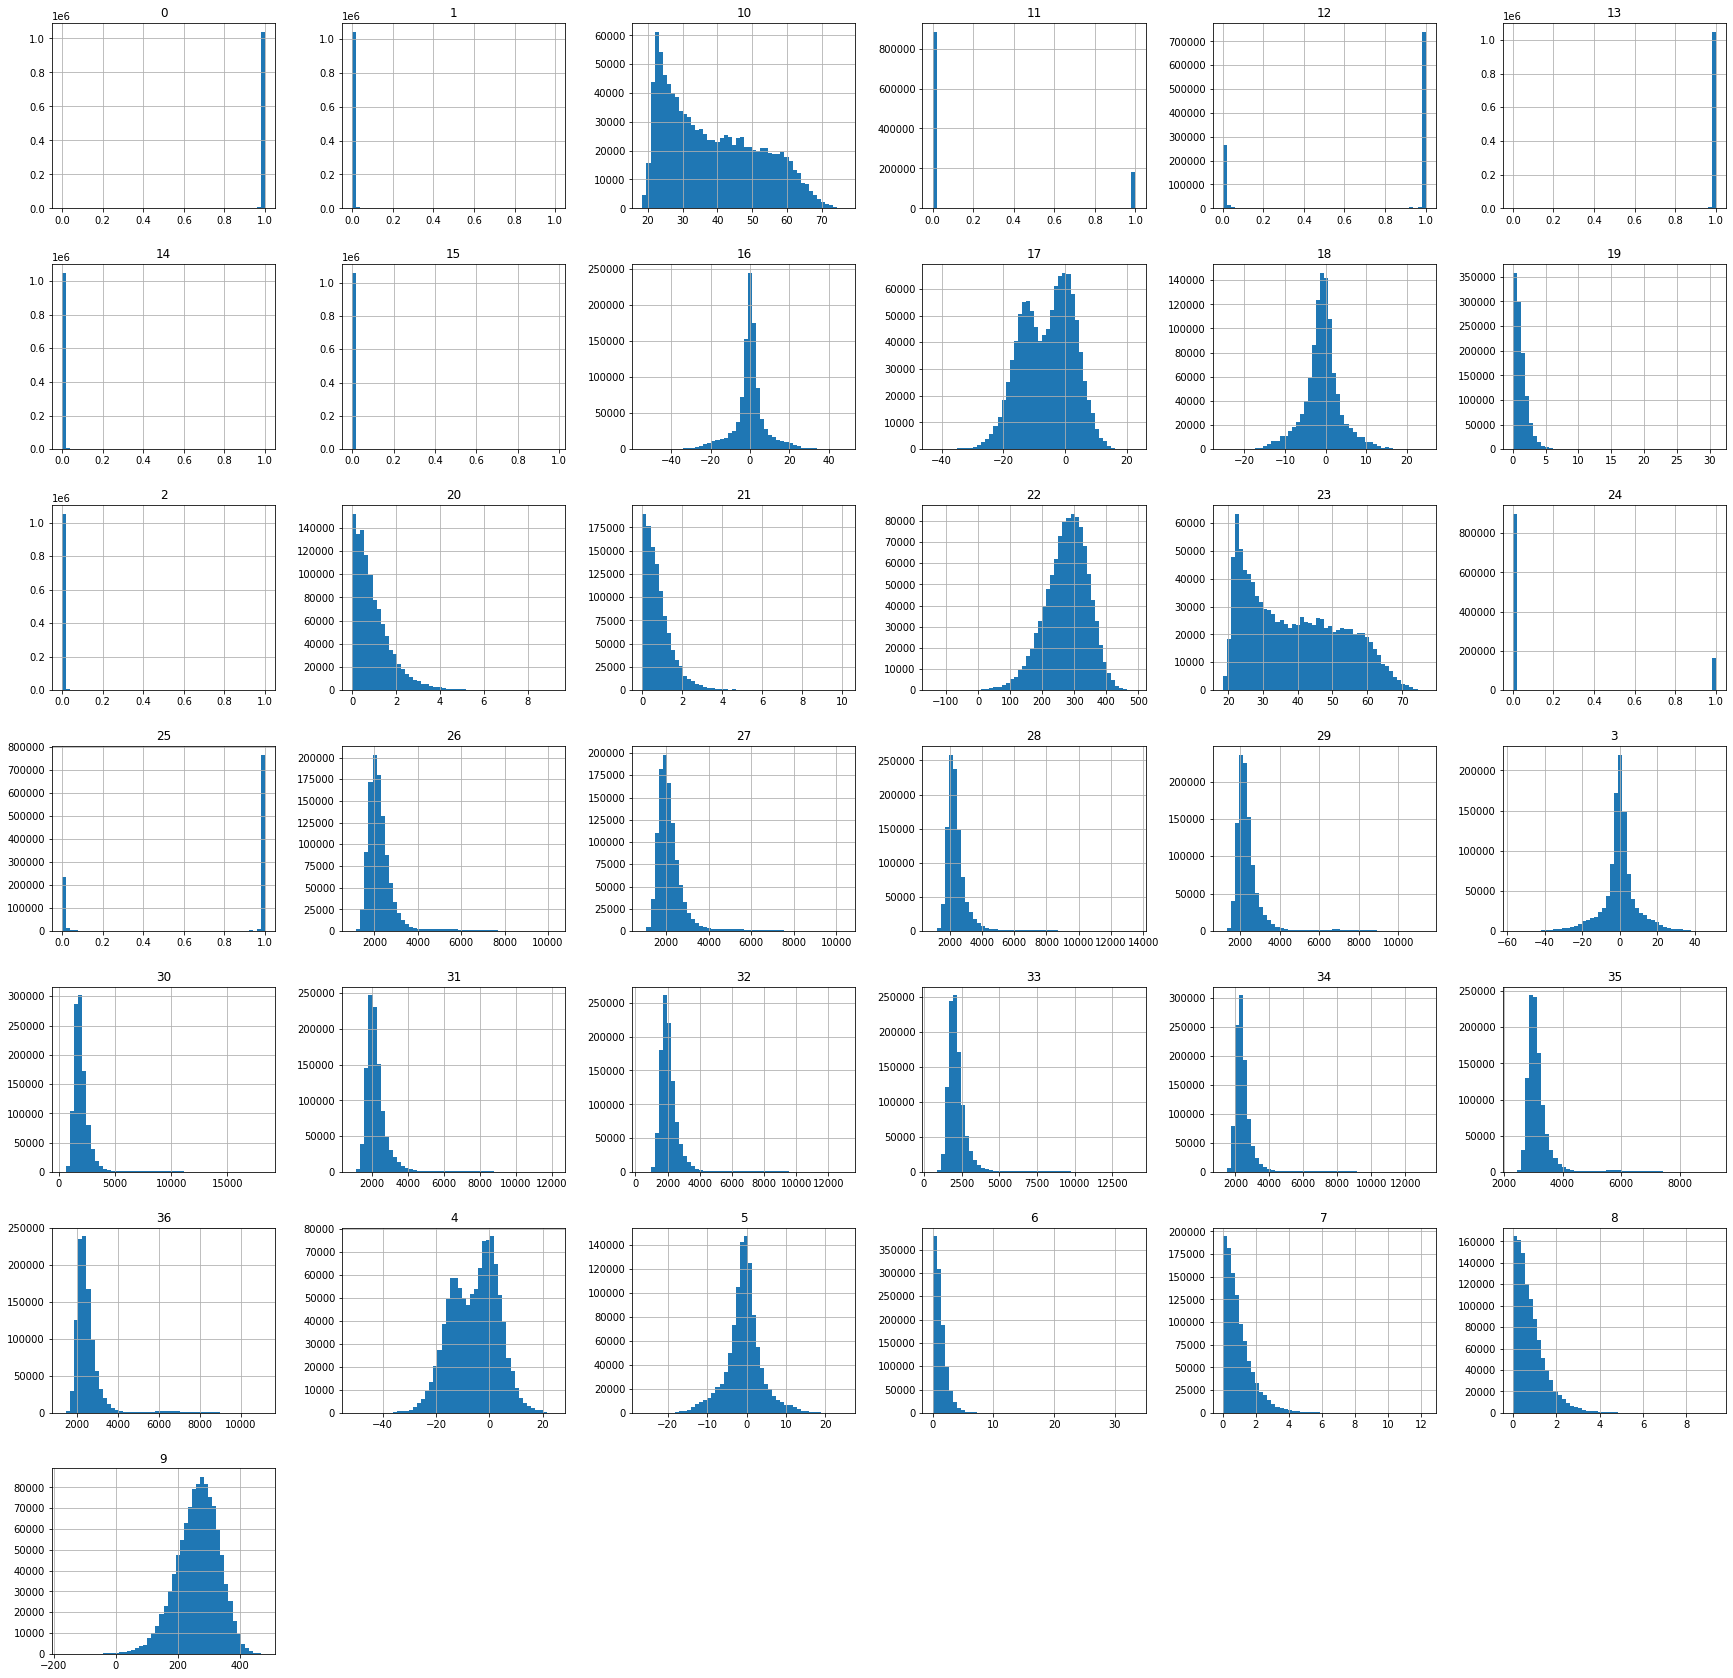

In [ ]:
df.hist(bins=50, figsize=(30,30))
plt.show()



**These histograms show that our dataset contains features that highly vary in magnitudes and range, which can affect the speed of our calculations and in some cases the results of algorithms. In other terms,  some features that are big in scale may become dominating and mislead the results of some algorithms like PCA, SVM,.. To get rid of all this, we have decided to scale all features within the same range (having 0 mean and a standard deviation of 1)**

In [ ]:
# Split training data into train and validation
X_train, X_test, y_train, y_test = train_test_split(xtrain, np.ravel(ytrain) ,test_size=0.2, shuffle=True)

# Scaling data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)
X_test_partial_scale = scaler.transform(xtest) # for submission

# Scaling whole data for submissions
scaler1 = StandardScaler()
scaler1.fit(xtrain)
X_train_whole_scale = scaler1.transform(xtrain)
X_test_whole_scale = scaler1.transform(xtest)

# 2- Applying feature selection using PCA


In [ ]:
pca = PCA()
pca.fit(X_train_scale)
print("\n\tExplained variance ratio in 1000 %:")
print((pca.explained_variance_ratio_*1000).round())


	Explained variance ratio in 1000 %:
[269.  62.  58.  55.  39.  37.  34.  33.  32.  31.  28.  27.  27.  26.
  25.  23.  23.  22.  21.  21.  20.  19.  18.  12.   9.   8.   4.   4.
   2.   2.   2.   2.   2.   1.   1.   0.   0.]


**Viewing the proportion of the dataset’s variance that lies along each principal component, we notice that some componants carry very little information.**

**Now let's see the minimum number of dimensions required to preserve 95% of the training set’s variance :**



In [ ]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print("the minimum number of dimensions required to preserve 95% of the training set’s variance is : ")
d

the minimum number of dimensions required to preserve 95% of the training set’s variance is : 


24

In [ ]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scale)
X_test_pca = pca.transform(X_test_scale)

# for submission
X_train_whole_pca = pca.fit_transform(X_train_whole_scale)
X_test_whole_pca = pca.transform(X_test_whole_scale)

**So we reduced dimensionality from 37 to 24, by losing 5% of our dataset's information.** 

**This can improve calculation time significantly for some classifiers, however it goes on the cost of accuracy! therefore we will use it only when needed.**

# 3- Naive Bayes Classifier


**We start by trying Naive Bayes Classifier even though it's a probabilistic algrithm and we expect to be highly influenced by the skewness of our dataset.**

---------------------------------- Gaussian Bayes Classifier  ----------------------------------

Fitting time: 0.513 s

Accuracy with original data  :  0.9746374607512366

Number of mislabeled points out of a total 213701 points : 5420


<Figure size 432x288 with 0 Axes>

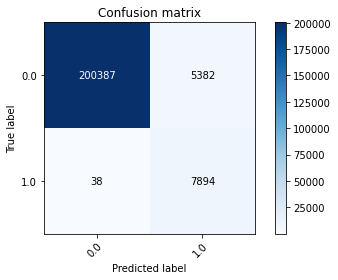

In [ ]:
print("----------------------------------\033[1m Gaussian Bayes Classifier \033[0;0m ----------------------------------")

GNB_clf = GaussianNB()

start = time.time()
GNB_clf.fit(X_train_scale, y_train)
print("\nFitting time: %0.3f s"%(time.time() - start))

y_pred = GNB_clf.predict(X_test_scale)
report(y_test, y_pred, X_test.shape[0], labels)

**This classifier gives a good accuracy with a remarkably low computational time. We notice that it has a high ratio of False Positives. However, it has a significantly low number of False Negatives, so it may be pertinent to use this classifier later in voting, if the other classifiers included have a low ratio of False positives.**

# 4- Linear Classifiers

## Logistic Regression

----------------------------------  Logistic Regression  ----------------------------------

Fitting time: 15.565 s

Accuracy with original data  :  0.9979878428271276

Number of mislabeled points out of a total 213701 points : 430


<Figure size 432x288 with 0 Axes>

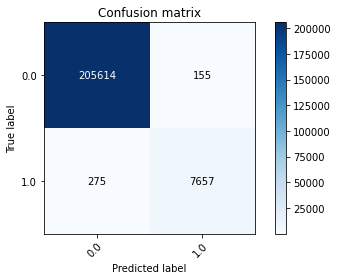

In [ ]:
print("---------------------------------- \033[1m Logistic Regression \033[0;0m ----------------------------------")
LR_clf = LogisticRegression()

start = time.time()
LR_clf.fit(X_train_scale, y_train)
print("\nFitting time: %0.3f s"%(time.time() - start))

y_pred = LR_clf.predict(X_test_scale)
report(y_test, y_pred, X_test.shape[0], labels)

In [ ]:

LR_clf = LogisticRegression( max_iter=1000)
LR_clf.fit(X_train_whole_scale, ytrain)
ytest = LR_clf.predict(X_test_whole_scale)
submission(LR_clf, X_test_whole_scale)

submission score : **0.997851306815**

----------------------------------  Logistic Regression  ----------------------------------

Adding weights to classes


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



Fitting time: 18.095 s

Accuracy with original data  :  0.9941507058928128

Number of mislabeled points out of a total 213701 points : 1250


<Figure size 432x288 with 0 Axes>

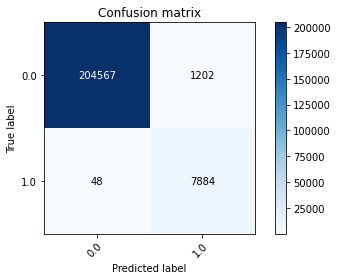

In [ ]:
print("---------------------------------- \033[1m Logistic Regression \033[0;0m ----------------------------------")
print('\nAdding weights to classes')
LR_clf = LogisticRegression(class_weight='balanced')

start = time.time()
LR_clf.fit(X_train_scale, y_train)
print("\nFitting time: %0.3f s"%(time.time() - start))

y_pred = LR_clf.predict(X_test_scale)
report(y_test, y_pred, X_test.shape[0], labels)

## Linear SVM Classifier

### Linear SVM with defaults parameters 

**Both classifiers have linear decision boundary, ad naturally it behave very similarly However,  LinearSVC approach differs from Logistic regression, as it doesn't assume a probabilistic model and it's formulated so that only points near the decision boundary really make a difference (Points that are "obvious" have no effect on the decision boundary)  Therefore it's interesting to see the results of both methods.**



----------------------------------  Linear SVC  ----------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



Fitting time: 48.858 s

Accuracy with scaled data  :  0.9980065605682706

Number of mislabeled points out of a total 213701 points : 426


<Figure size 432x288 with 0 Axes>

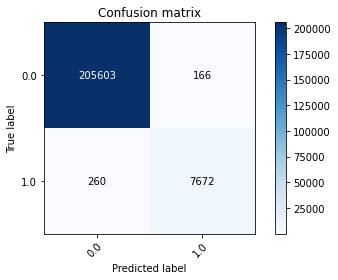

In [ ]:
print("---------------------------------- \033[1m Linear SVC \033[0;0m ----------------------------------")

LSVM_clf = LinearSVC(C=1, loss="hinge")
start = time.time()
LSVM_clf.fit(X_train_scale, y_train)
print("\nFitting time: %0.3f s"%(time.time() - start))

y_pred = LSVM_clf.predict(X_test_scale)
report(y_test, y_pred, X_test.shape[0], labels, "scaled")

### Tuning over hyperparameter **C**

**This hyperparameter is important as it represents the inverse of regularization strength so it controls the bias/variance tradeoff, and in particular it dictates how sensitive the decision boundary is to outliers.**



/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


The best C is 0.1  with an average validation score equal to  0.9981001469255013

Fitting the best estimator


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



Accuracy with scaled data  :  0.9980159194388422

Number of mislabeled points out of a total 213701 points : 424


<Figure size 432x288 with 0 Axes>

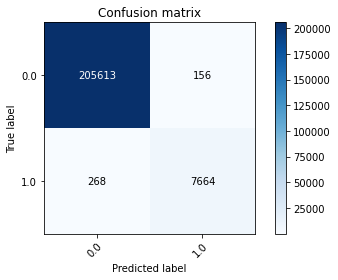

In [ ]:
C_grid_lsvm = {'C': [1e-3,1e-2,1e-1,1]}
LSVM_clf = LinearSVC(loss="hinge")
grid = GridSearchCV(LSVM_clf, C_grid_lsvm, cv=5, n_jobs=-1, scoring='accuracy')
grid.fit(X_train_scale, np.ravel(y_train))

C_best = grid.best_params_.get('C')
print('The best C is', C_best, ' with an average validation score equal to ', grid.best_score_)
  
print('\nFitting the best estimator')
LSVM_clf = LinearSVC(loss="hinge", C=C_best)
LSVM_clf.fit(X_train_scale, y_train)
y_pred = LSVM_clf.predict(X_test_scale)
report(y_test, y_pred, X_test.shape[0], labels, "scaled")

**The result given by LinearSVC is close to LogisticRegression, which is expected. It gave a slightly better result likely because SVM handles outliers better than LR.**


In [ ]:
LSVM_clf = LinearSVC(C=0.1, loss="hinge")
LSVM_clf.fit(X_train_whole_scale, ytrain)

submission(LSVM_clf, X_test_whole_scale)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Submission result : **0.997879031889**

### Linear SVM with PCA

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



Fitting time: 9.064 s

Accuracy with scaled data  :  0.9970940706875494

Number of mislabeled points out of a total 213701 points : 621


<Figure size 432x288 with 0 Axes>

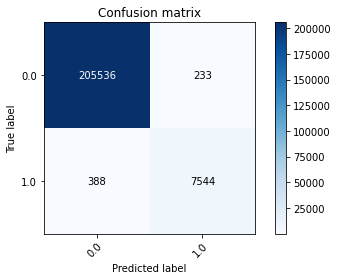

In [ ]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train_scale)

LSVM_clf = LinearSVC(C=0.1, loss="hinge")
start = time.time()
LSVM_clf.fit(X_reduced, y_train)
print("\nFitting time: %0.3f s"%(time.time() - start))

X_test_reduced =  pca.transform(X_test_scale)
y_pred = LSVM_clf.predict(X_test_reduced)
report(y_test, y_pred, X_test.shape[0], labels, "scaled")

**Applying PCA before LinearSVC resulted in worse accuracy. This is not surprising, as SVM can handle big number of features, and we already have only 37. So PCA isn't expected to improve the results.**

# 5- Neural Network

### Tuning over **batch_size** and **epochs**

In [ ]:
def create_model():

  optimizer ='adam'
  init_mode='uniform'
  input_shape = X_train_scale[0].shape

  model = Sequential()
  model.add(Dense(100, input_shape= input_shape, kernel_initializer= init_mode, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer=optimizer, 
                loss='binary_crossentropy', 
                metrics=['accuracy'])
  return model

In [ ]:
model = KerasClassifier(build_fn=create_model, verbose=0)

epochs=[10, 20, 30]
batch_size=[32, 64,128]
param_grid = dict(epochs=epochs, batch_size=batch_size)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring="accuracy", cv=4, refit=False, n_jobs=4)

results = grid.fit(X_train_whole_scale, ytrain)
results

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=4, error_score=nan,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fc0c225a3c8>,
             iid='deprecated', n_jobs=4,
             param_grid={'batch_size': [32, 64, 128], 'epochs': [10, 20, 30]},
             pre_dispatch='2*n_jobs', refit=False, return_train_score=False,
             scoring='accuracy', verbose=0)

In [ ]:
result = pd.DataFrame(grid.cv_results_)[['rank_test_score',
                                          'mean_test_score', 
                                          'param_batch_size',
                                           'param_epochs'
                                         ]]
result.columns = ['rank test', 'score test', 'batch_size', 'epochs']
result

rank test  score test batch_size epochs
0          9    0.998567         32     10
1          4    0.998616         32     20
2          6    0.998587         32     30
3          1    0.998635         64     10
4          7    0.998586         64     20
5          8    0.998578         64     30
6          3    0.998617        128     10
7          5    0.998600        128     20
8          2    0.998622        128     30

In [ ]:
# summarize results
print("Best: %f using %s" % (results.best_score_, results.best_params_))

Best: 0.998635 using {'batch_size': 64, 'epochs': 10}


###Tuning over 'optimizer'

In [ ]:
def create_model(optimizer='adam'):
  input_shape = X_train_scale[0].shape
  init_mode='uniform'

  model = Sequential()
  model.add(Dense(100, input_shape= input_shape, kernel_initializer= init_mode, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer=optimizer, 
                loss='binary_crossentropy', 
                metrics=['accuracy'])
  return model

model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=64, verbose=0)
# define the grid search parameters
optimizer = ['SGD', 'RMSprop',  'Adam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring="accuracy", cv=4, refit=False, n_jobs=4)
results = grid.fit(X_train_whole_scale, ytrain)

In [ ]:
# summarize results
print("Best: %f using %s" % (results.best_score_, results.best_params_))

Best: 0.998610 using {'optimizer': 'Adam'}


In [ ]:
result = pd.DataFrame(grid.cv_results_)[['rank_test_score',
                                          'mean_test_score', 
                                          'param_optimizer'
                                         ]]
result.columns = ['rank test', 'score test', 'optimizer']
result

rank test  score test optimizer
0          3    0.998157       SGD
1          2    0.998387   RMSprop
2          1    0.998610      Adam

### Tuning over **network weight initialization**

In [ ]:
def create_model(init_mode='uniform'):
  input_shape = X_train_scale[0].shape
  optimizer = 'adam'

  model = Sequential()
  model.add(Dense(100, input_shape= input_shape, kernel_initializer= init_mode, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer=optimizer, 
                loss='binary_crossentropy', 
                metrics=['accuracy'])
  return model

model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=64, verbose=0)
# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(init_mode=init_mode)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring="accuracy", cv=3, refit=False, n_jobs=4)
results = grid.fit(X_train_whole_scale, ytrain)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
# summarize results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))

Best: 0.998633 using {'init_mode': 'normal'}


In [ ]:
result = pd.DataFrame(grid.cv_results_)[['rank_test_score',
                                          'mean_test_score', 
                                          'param_init_mode'
                                         ]]
result.columns = ['rank test', 'score test', 'init_mode']
result

rank test  score test       init_mode
0          3    0.998607         uniform
1          4    0.998584   lecun_uniform
2          1    0.998633          normal
3          8    0.962945            zero
4          5    0.998555   glorot_normal
5          2    0.998617  glorot_uniform
6          7    0.998543       he_normal
7          6    0.998549      he_uniform

### Tuning over the **activation function**

In [ ]:
def create_model(activation='relu'):
  input_shape = X_train_scale[0].shape
  optimizer = 'adam'
  init_mode= 'normal'

  model = Sequential()
  model.add(Dense(100, input_shape= input_shape, kernel_initializer= init_mode, activation=activation))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer=optimizer, 
                loss='binary_crossentropy', 
                metrics=['accuracy'])
  return model

# define the grid search parameters
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=64, verbose=0)
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring="accuracy", cv=4, refit=False, n_jobs=4)
results = grid.fit(X_train_whole_scale, ytrain)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
# summarize results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))

Best: 0.998642 using {'activation': 'relu'}


In [ ]:
result = pd.DataFrame(grid.cv_results_)[['rank_test_score',
                                          'mean_test_score', 
                                          'param_activation'
                                         ]]
result.columns = ['rank test', 'score test', 'activation']
result

rank test  score test    activation
0          7    0.998149       softmax
1          4    0.998580      softplus
2          3    0.998588      softsign
3          1    0.998642          relu
4          2    0.998635          tanh
5          6    0.998312       sigmoid
6          5    0.998371  hard_sigmoid
7          8    0.997875        linear

### Tuning over the **Dropout Regularization**

In [ ]:
from tensorflow.keras.layers import Dropout
from keras.constraints import maxnorm
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from sklearn.model_selection import  cross_val_score, cross_validate, cross_val_predict, GridSearchCV

def create_model(dropout_rate=0.0, weight_constraint=0):
  input_shape = X_train_scale[0].shape
  optimizer = 'adam'
  init_mode= 'normal'
  activation='relu'
  
  model = Sequential()
  model.add(Dense(100, input_shape= input_shape, kernel_initializer= init_mode, activation=activation, kernel_constraint=maxnorm(weight_constraint)))
  model.add(Dropout(dropout_rate))
  model.add(Dense(1, kernel_initializer= init_mode, activation='sigmoid'))
  model.compile(optimizer=optimizer, 
                loss='binary_crossentropy', 
                metrics=['accuracy'])
  return model

model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=64, verbose=0)
# define the grid search parameters
weight_constraint = [1, 3,  5]
dropout_rate = [0.0, 0.2, 0.5 ]
param_grid = dict(dropout_rate=dropout_rate, weight_constraint=weight_constraint)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring="accuracy", cv=4, refit=False, n_jobs=4)
results = grid.fit(X_train_whole_scale, ytrain)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
# summarize results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))

Best: 0.998640 using {'dropout_rate': 0.0, 'weight_constraint': 5}


In [ ]:
result = pd.DataFrame(grid.cv_results_)[['rank_test_score',
                                          'mean_test_score', 
                                          'param_weight_constraint',
                                          'param_dropout_rate'
                                         ]]
result.columns = ['rank test', 'score test', 'weight_constraint', 'dropout_rate']
result

rank test  score test weight_constraint dropout_rate
0          4    0.998581                 1            0
1          5    0.998558                 3            0
2          1    0.998640                 5            0
3          6    0.998533                 1          0.2
4          2    0.998619                 3          0.2
5          3    0.998594                 5          0.2
6          9    0.998449                 1          0.5
7          8    0.998525                 3          0.5
8          7    0.998530                 5          0.5

###Tuning over **'Units'**

In [ ]:
from tensorflow.keras.layers import Dropout
from keras.constraints import maxnorm
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from sklearn.model_selection import  cross_val_score, cross_validate, cross_val_predict, GridSearchCV

def create_model(neurons=10):
  input_shape = X_train_scale[0].shape
  optimizer = 'adam'
  init_mode= 'normal'
  activation='relu'
  weight_constraint=5
  
  model = Sequential()
  model.add(Dense(units=neurons, input_shape= input_shape, kernel_initializer= init_mode, activation=activation, kernel_constraint=maxnorm(weight_constraint)))
  model.add(Dense(1, kernel_initializer= init_mode, activation='sigmoid'))
  model.compile(optimizer=optimizer, 
                loss='binary_crossentropy', 
                metrics=['accuracy'])
  return model

model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=64, verbose=0)
# define the grid search parameters
neurons = [10, 20, 50, 100]
param_grid = dict(neurons=neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring="accuracy", cv=4, refit=False, n_jobs=4)
results = grid.fit(X_train_whole_scale, ytrain)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
# summarize results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))

Best: 0.998548 using {'neurons': 100}


In [ ]:
import pandas as pd
result = pd.DataFrame(grid.cv_results_)[['rank_test_score',
                                          'mean_test_score', 
                                          'param_neurons'
                                         ]]
result.columns = ['rank test', 'score test', 'neurons']
result

rank test  score test neurons
0          4    0.998209      10
1          3    0.998447      20
2          2    0.998507      50
3          1    0.998548     100

**Using a neural network with a simple architecture, we could tune it to obtain a better accuracy than all previous classifiers. This is not surprising as neural networks have the ability to learn and model non-linear and complex relationships, also it was trained on a large dataset which makes it perform well**

# 6- Decision Trees

Given that decision trees have high risk to overfit, we didn't put so much focus on training it and tnuing its parameters. We rather focused on ensemble methods in which trees are used as base estimator and overfitting is controlled with  boosting or bagging techniques.

Below we have built a decision tree with a max depth of 4 and ploted a visual representation of the tree. We can explore this representation to identify some important variables in our dataset like feature 36 on top of the tree. However, we obtained a poor accuracy compared with previous algorithms. This can be interpreted as the result the sensitivity of decision tress to noise and outliers. 

A possible solution to improve accuracy may be increasing the maximum depth with, but we risk overfitting. It's true that we can relatively overcome this issue with pruning, but we chose to move to ensemble methods for more robustness.
 

----------------------------------  Decision tree  ----------------------------------

Fitting time: 15.828 s

Accuracy with scaled data  :  0.9969864436759772

Number of mislabeled points out of a total 213701 points : 644


<Figure size 432x288 with 0 Axes>

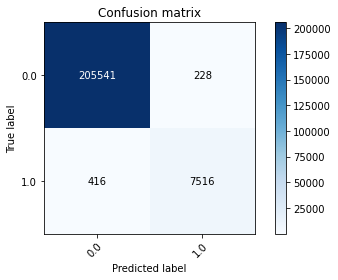

In [ ]:
print("---------------------------------- \033[1m Decision tree \033[0;0m ----------------------------------")

tree_clf = DecisionTreeClassifier(max_depth=4)

start = time.time()
tree_clf.fit(X_train_scale, y_train)
print("\nFitting time: %0.3f s"%(time.time() - start))

y_pred = tree_clf.predict(X_test_scale)
report(y_test, y_pred, X_test.shape[0], labels, "scaled")

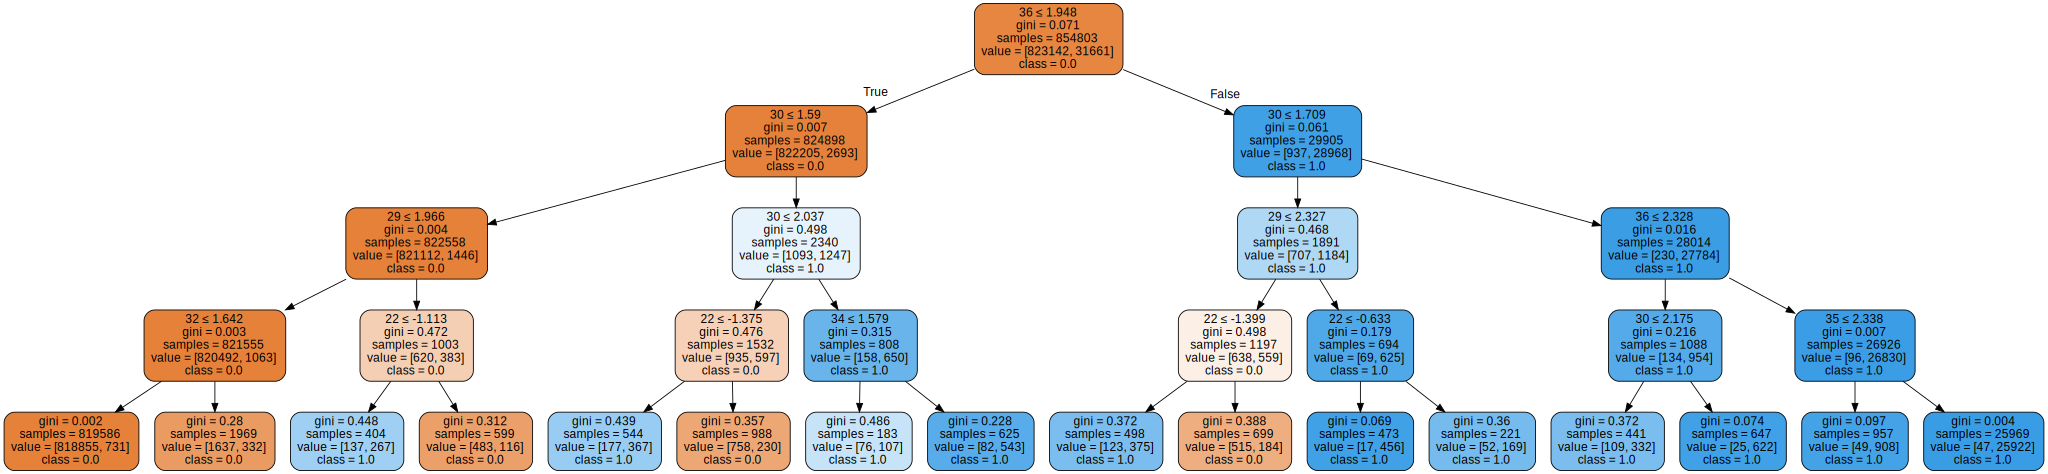

In [ ]:
from sklearn.tree import export_graphviz
import graphviz 

f_names = [str(i) for i in range(0, X_train.shape[1])]
l_names = [str(i) for i in labels]
dot_data = export_graphviz( tree_clf,
                           out_file=None,
                           feature_names=f_names, class_names= l_names,
                           rounded=True, filled=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph

# 7- Random Forest

Random Forest could be good as it performs bagging on decision trees. In other terms, it fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy.

However it is slow, and achieving a good accuracy can be expensive in terms of computational time.

In [ ]:
RF_clf =RandomForestClassifier(criterion="gini", class_weight='balanced')
p_grid_RF = {'n_estimators': [20, 50],
             'max_features': ['log2', 'sqrt'],
             'max_depth': [5, 10, 15]}   

grid_RF = GridSearchCV(estimator=RF_clf, param_grid=p_grid_RF, scoring="accuracy", cv=3, verbose=True, n_jobs=4)
grid_RF.fit(X_train_scale, y_train.ravel())
print("Best Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))

# Features' importance
best_params=grid_RF.best_params_
RF_clf = RandomForestClassifier(criterion="gini", class_weight='balanced',
                                max_features=best_params['max_features'],  
                                n_estimators=best_params["n_estimators"],
                                max_depth= best_params['max_depth'])
RF_clf.fit(X_train_scale,y_train)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed: 22.2min finished


Best Score: 0.9978228901521735
Best params: {'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 50}


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=15, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
import pandas as pd
results = pd.DataFrame(grid_RF.cv_results_)[['rank_test_score',
                                          'mean_test_score', 
                                          'param_n_estimators', 
                                          'param_max_depth',
                                          'param_max_features'
                                         ]]
results.columns = ['rank test', 'score test','n_estimators', 'max_depth', 'max_features']
results

rank test  score test n_estimators max_depth max_features
0          10    0.992074           20         5         log2
1          11    0.991872           50         5         log2
2          12    0.991859           20         5         sqrt
3           9    0.992313           50         5         sqrt
4           8    0.996777           20        10         log2
5           7    0.996817           50        10         log2
6           6    0.996855           20        10         sqrt
7           5    0.997004           50        10         sqrt
8           4    0.997716           20        15         log2
9           2    0.997812           50        15         log2
10          3    0.997721           20        15         sqrt
11          1    0.997823           50        15         sqrt

Feature ranking:
1. feature 34 representing 34 (0.226061)
2. feature 29 representing 29 (0.199240)
3. feature 30 representing 30 (0.137280)
4. feature 32 representing 32 (0.096176)
5. feature 36 representing 36 (0.074665)
6. feature 35 representing 35 (0.060315)
7. feature 28 representing 28 (0.052208)
8. feature 26 representing 26 (0.050725)
9. feature 31 representing 31 (0.036924)
10. feature 33 representing 33 (0.022741)


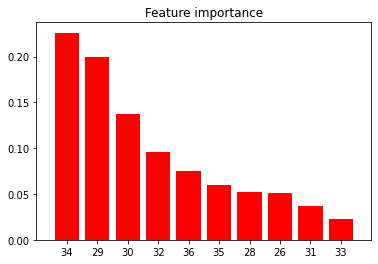

In [ ]:
importances = RF_clf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

f_names = [str(i) for i in range(0, X_train.shape[1])]
for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], f_names[indices[f]], importances[indices[f]]))

plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

In [ ]:
RF_clf =RandomForestClassifier(criterion="gini", max_features ='sqrt', max_depth=15)
p_grid_RF = {'n_estimators': [100, 200, 300]}

grid_RF = GridSearchCV(estimator=RF_clf, param_grid=p_grid_RF, scoring="accuracy", cv=3, verbose=True, n_jobs=4)
grid_RF.fit(X_train_whole_scale, ytrain)
print("Best Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   9 out of   9 | elapsed: 71.9min finished


Best Score: 0.9978736626161436
Best params: {'n_estimators': 300}


In [ ]:
import pandas as pd
results = pd.DataFrame(grid_RF.cv_results_)[['rank_test_score',
                                          'mean_test_score', 
                                          'param_n_estimators', 
                                         ]]
results.columns = ['rank test', 'score test','n_estimators']
results

rank test  score test n_estimators
0          2    0.997861          100
1          3    0.997856          200
2          1    0.997874          300

We're going to work with 100 estimators, as increasing it to 300 came with a slight improvement in terms of score test but with a high cost in terms of computational time.

In [ ]:
submission(grid_RF, X_test_whole_scale)

Submission score:  **0.9973** this is very bad.. Let's try another thing, since our dataset is higly skewed, we can force the random forest classifier to focus much more on the minority class samples by adding weights to classes.

In [ ]:
RF_clf =RandomForestClassifier(criterion="gini", class_weight='balanced', max_features ='sqrt', max_depth=15)
p_grid_RF = {'min_samples_split': [100, 200, 300]}

grid_RF = GridSearchCV(estimator=RF_clf, param_grid=p_grid_RF, scoring="accuracy", cv=3, verbose=True, n_jobs=-1)
grid_RF.fit(X_train_whole_scale, ytrain)
print("Best Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 38.3min finished


Best Score: 0.9959972073104079
Best params: {'min_samples_split': 100}


In [ ]:
import pandas as pd
results = pd.DataFrame(grid_RF.cv_results_)[['rank_test_score',
                                          'mean_test_score', 
                                          'param_min_samples_split', 
                                         ]]
results.columns = ['rank test', 'score test','min_samples_split']
results

rank test  score test min_samples_split
0          1    0.995997               100
1          2    0.994785               200
2          3    0.993997               300


Fitting time: 2018.773 s

Accuracy with original data  :  0.9960458771835415

Number of mislabeled points out of a total 213701 points : 845


<Figure size 432x288 with 0 Axes>

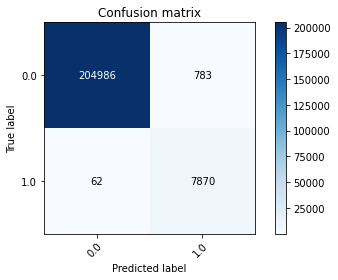

In [ ]:
RF_clf =RandomForestClassifier(n_estimators = 300,criterion="gini", class_weight='balanced', max_features ='sqrt', max_depth=15, min_samples_split =100 )
start = time.time()
RF_clf.fit(X_train_scale, y_train)
print("\nFitting time: %0.3f s"%(time.time() - start))

y_pred = RF_clf.predict(X_test_scale)
report(y_test, y_pred, X_test.shape[0], labels)

Interpretation:

Given the results above, we can notice that:
- Accuracy is proportional to both the number of estimators and the maximum depth of trees in the results we've got so far which means that we didn't reach the best estimator however it's already expensive in computational time. Therefore we won't go any further.
- Random Forest provides the ranking of features in terms of their importance, and we can notice that unlike what we obtained with the decision tree classifier, the feature 36 is rather the 5th important one. 

# 8- Boosting

##Adaptative Boosting : AdaBoost

###AdaBoost with default parameters


Fitting time: 206.447 s

Accuracy with original data  :  0.9976556029218394

Number of mislabeled points out of a total 213701 points : 501


<Figure size 432x288 with 0 Axes>

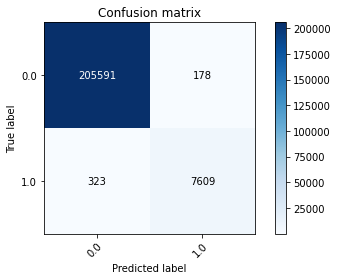

In [ ]:
ada_clf=AdaBoostClassifier()
start = time.time()
ada_clf.fit(X_train_scale, y_train)
print("\nFitting time: %0.3f s"%(time.time() - start))

y_pred = ada_clf.predict(X_test_scale)
report(y_test, y_pred, X_test.shape[0], labels)

**The results obtained with default parameters (50 weak learners and lr = 1) are not so good. This is not surprising as the number of learners is low. However, we notice that AdaBoost is quite slow, therefore, we can't try a significant number of estimators.**

###Tuning over learning_rate and n_estimators

In [ ]:
ada_clf=AdaBoostClassifier()
param_grid={'learning_rate':[.1, 0.05], 'n_estimators' :[50, 100, 200]}
grid=GridSearchCV(estimator=ada_clf,param_grid=param_grid,cv=2, n_jobs=-1, verbose =1, refit = False)
start = time.time()
grid.fit(X_train_whole_scale, ytrain)
print("total time used for fitting: %s"%(time.time() - start))
ada_clf.fit(X_train_whole_scale, ytrain)

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 42.8min finished


total time used for fitting: 2570.931205511093


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [ ]:
  import pandas as pd
  result = pd.DataFrame(grid.cv_results_)[['rank_test_score',
                                          'mean_test_score', 
                                          'param_learning_rate',
                                           'param_n_estimators'
                                         ]]
  result.columns = ['rank test', 'score test', 'learning_rate', 'n_estimators']
  print(result)

   rank test  score test learning_rate n_estimators
0          5    0.997250           0.1           50
1          3    0.997534           0.1          100
2          1    0.997759           0.1          200
3          6    0.996625          0.05           50
4          4    0.997264          0.05          100
5          2    0.997598          0.05          200


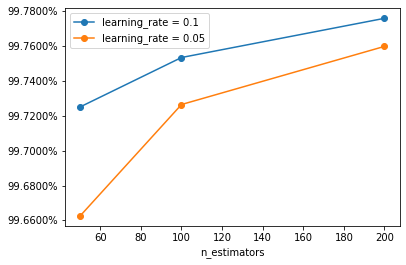

In [ ]:
df1 = result.loc[result['learning_rate'] == 0.1]
ax=df1.plot(x='n_estimators', y='score test',style='-o', label ='learning_rate = 0.1')
df2 = result.loc[result['learning_rate'] == 0.05]
df2.plot(x='n_estimators', y='score test',style='-o', label ='learning_rate = 0.05', ax=ax)
vals = ax.get_yticks()
ax = ax.set_yticklabels(['{:,.4%}'.format(x) for x in vals])

We see that for both values of learning rate, we most likely didn't achieve convergence yet. 

learning_rate = 0.1 gives better results, however this is likely because for learning_rate 0.05, convergence is slower and we need a more important number of iterations to have good results, also we notice that its curve is getting closer to the other one, which means that with superior values for number of estimators, it will surpass it and thus give better score.

In [ ]:
ada_clf=AdaBoostClassifier()
param_grid={'learning_rate':[.1, 0.05], 'n_estimators' :[400, 800]}
grid=GridSearchCV(estimator=ada_clf,param_grid=param_grid,cv=2, n_jobs=-1, verbose =1, refit = False)
start = time.time()
grid.fit(X_train_whole_scale, ytrain)
print("total time used for fitting: %s"%(time.time() - start))
ada_clf.fit(X_train_whole_scale, ytrain)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed: 164.0min finished


total time used for fitting: 9841.576326608658


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [ ]:
  result2 = pd.DataFrame(grid.cv_results_)[['rank_test_score',
                                          'mean_test_score', 
                                          'param_learning_rate',
                                           'param_n_estimators'
                                         ]]
  result2.columns = ['rank test', 'score test', 'learning_rate', 'n_estimators']
  print(result2)

   rank test  score test learning_rate n_estimators
0          2    0.997937           0.1          400
1          1    0.998117           0.1          800
2          4    0.997802          0.05          400
3          3    0.997908          0.05          800


In [ ]:
#Combining both results
merged_results = pd.merge(result, result2, on=['learning_rate', 'n_estimators','score test','rank test'], how = 'outer')
merged_results

rank test  score test  learning_rate  n_estimators
0          5    0.997250           0.10          50.0
1          3    0.997534           0.10         100.0
2          1    0.997759           0.10         200.0
3          6    0.996625           0.05          50.0
4          4    0.997264           0.05         100.0
5          2    0.997598           0.05         200.0
6          2    0.997937           0.10         400.0
7          1    0.998117           0.10         800.0
8          4    0.997802           0.05         400.0
9          3    0.997908           0.05         800.0

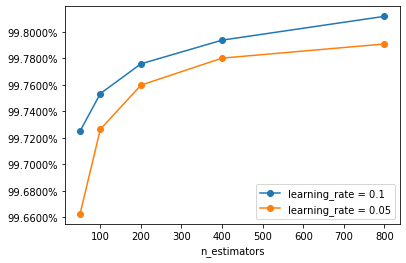

In [ ]:
#Combining both results
df3 = merged_results.loc[merged_results['learning_rate'] == 0.1]
ax=df3.plot(x='n_estimators', y='score test',style='-o', label ='learning_rate = 0.1')
df4 = merged_results.loc[merged_results['learning_rate'] == 0.05]
df4.plot(x='n_estimators', y='score test',style='-o', label ='learning_rate = 0.05', ax=ax)
vals = ax.get_yticks()
ax = ax.set_yticklabels(['{:,.4%}'.format(x) for x in vals])

**Most likely, the algorithm still needs more iterations to converge for both values of learning rate. However, the second gridsearch with only 2x2 hyperparameters to tune, and with n_estimators not exceeding 800, took 169 minutes, therefore, pushing the algorithm to reach the best accuracy by still increasing the number of estimators will be very costy in computational time. So we'll work with the best parameters we obtained so far.**

###Training AdaBoost with best parameters


Fitting time: 3901.865 s

Accuracy with original data  :  0.9981282258857002

Number of mislabeled points out of a total 213701 points : 400


<Figure size 432x288 with 0 Axes>

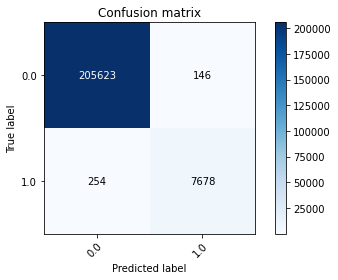

In [ ]:
ada_clf=AdaBoostClassifier(learning_rate = 0.1, n_estimators= 800)
start = time.time()
ada_clf.fit(X_train_scale, y_train)
print("\nFitting time: %0.3f s"%(time.time() - start))

y_pred = ada_clf.predict(X_test_scale)
report(y_test, y_pred, X_test.shape[0], labels)

**We see that the Training of the best model we could find took more than 1 hour. The accuracy is good but can still improve. However, this will come on the cost of computational time.**


In [ ]:
submission(ada_clf,X_test_whole_scale)

Submission score : 0.997753063621

## Gradient Boosting

**Here we're going to try some gradient boosting algorithms, mainly XGBoost, Lightgbm and CatBoost, as an attempt to achieve better performances.** 

**These algorithms share the common approach of creating new models to predict the residuals or errors of prior models. Those models are then added together to make the final prediction. They all use a gradient descent algorithm to minimize the loss when adding new model.**

##XGBoost Classifier

**XGboost splits up to the specified max_depth hyperparameter and then starts pruning the tree backwards and removes splits beyond which there is no positive gain. It uses this approach since sometimes a split of no loss reduction may be followed by a split with loss reduction.**

**We are going to use the native API of XGBoost as it automatically finds the best number of boosting rounds and has a built-in cross validation function.First we trained it with its defaults parameters. Since it gave us quite acceptable results, we proceeded to tuning its most important parameters.**

### XGBoost'cv with **default parameters**

In [ ]:
dtrain = xgb.DMatrix(X_train_scale, label=y_train)
dtest = xgb.DMatrix(X_test_scale, label=y_test)

params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:squarederror',
}

params['eval_metric'] = "mae"
num_boost_round = 999

model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

In [ ]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'mae'},
    early_stopping_rounds=10
)
cv_results

train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
0         0.348714       0.000011       0.351687      0.000044
1         0.246846       0.000022       0.247434      0.000086
2         0.173799       0.000023       0.174054      0.000093
3         0.122247       0.000025       0.122944      0.000082
4         0.087215       0.000037       0.086919      0.000100
5         0.061311       0.000037       0.062013      0.000125
6         0.043630       0.000043       0.044385      0.000117
7         0.031738       0.000028       0.032064      0.000138
8         0.022994       0.000034       0.023385      0.000097
9         0.016901       0.000029       0.017376      0.000107
10        0.012660       0.000029       0.013120      0.000100
11        0.009652       0.000101       0.010176      0.000119
12        0.007508       0.000034       0.008133      0.000113
13        0.006079       0.000062       0.006687      0.000124
14        0.005056       0.000039       0.005674      0.000126
15        0.004345       0.000034       0.004979      0.000129
16        0.003849       0.000016       0.004505      0.000125
17        0.003529       0.000029       0.004175      0.000126
18        0.003277       0.000022       0.003939      0.000126
19        0.003128       0.000016       0.003785      0.000125
20        0.003009       0.000017       0.003671      0.000126
21        0.002927       0.000025       0.003607      0.000124
22        0.002869       0.000037       0.003562      0.000127
23        0.002833       0.000030       0.003532      0.000134
24        0.002803       0.000023       0.003513      0.000126
25        0.002786       0.000032       0.003501      0.000134
26        0.002764       0.000027       0.003495      0.000124
27        0.002748       0.000036       0.003491      0.000119
28        0.002741       0.000042       0.003493      0.000115
29        0.002730       0.000043       0.003493      0.000120
30        0.002711       0.000037       0.003488      0.000119
31        0.002699       0.000039       0.003485      0.000120

In [ ]:
cv_results['test-mae-mean'].min()

0.0034852

### Tuning over  **max_depth** , **min_child_weight**

In [ ]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]

# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=9, min_child_weight=5
	MAE 0.0031469999999999996 for 27 rounds
CV with max_depth=9, min_child_weight=6
	MAE 0.0031664000000000006 for 27 rounds
CV with max_depth=9, min_child_weight=7
	MAE 0.0031872 for 27 rounds
CV with max_depth=10, min_child_weight=5
	MAE 0.0031336000000000003 for 28 rounds
CV with max_depth=10, min_child_weight=6
	MAE 0.0031556 for 29 rounds
CV with max_depth=10, min_child_weight=7
	MAE 0.0031704000000000003 for 27 rounds
CV with max_depth=11, min_child_weight=5
	MAE 0.0031092000000000003 for 27 rounds
CV with max_depth=11, min_child_weight=6
	MAE 0.0031506 for 27 rounds
CV with max_depth=11, min_child_weight=7
	MAE 0.0031572 for 27 rounds
Best params: 11, 5, MAE: 0.0031092000000000003


In [ ]:
params['max_depth'] = 11
params['min_child_weight'] = 5

### Tuning over **subsample**  and **colsample** 

In [ ]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

min_mae = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with subsample=1.0, colsample=1.0
	MAE 0.0031092000000000003 for 27 rounds
CV with subsample=1.0, colsample=0.9
	MAE 0.0031287999999999997 for 28 rounds
CV with subsample=1.0, colsample=0.8
	MAE 0.0032203999999999996 for 27 rounds
CV with subsample=1.0, colsample=0.7
	MAE 0.0033124 for 28 rounds
CV with subsample=0.9, colsample=1.0
	MAE 0.0031718 for 28 rounds
CV with subsample=0.9, colsample=0.9
	MAE 0.003238 for 28 rounds
CV with subsample=0.9, colsample=0.8
	MAE 0.0033084000000000004 for 27 rounds
CV with subsample=0.9, colsample=0.7
	MAE 0.0033439999999999998 for 27 rounds
CV with subsample=0.8, colsample=1.0
	MAE 0.003229 for 27 rounds
CV with subsample=0.8, colsample=0.9
	MAE 0.0032898 for 27 rounds
CV with subsample=0.8, colsample=0.8
	MAE 0.0033698 for 27 rounds
CV with subsample=0.8, colsample=0.7
	MAE 0.0034346000000000003 for 27 rounds
CV with subsample=0.7, colsample=1.0
	MAE 0.0033066 for 27 rounds
CV with subsample=0.7, colsample=0.9
	MAE 0.0033807999999999998 for 28 r

In [ ]:
params['subsample'] = 1.
params['colsample_bytree'] = 1.

### Tuning over **eta**  

In [ ]:
%time
# This can take some time…
min_mae = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    %time cv_results = xgb.cv(params, dtrain, num_boost_round=num_boost_round, seed=42, nfold=5, metrics=['mae'], early_stopping_rounds=10) 
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta
print("Best params: {}, MAE: {}".format(best_params, min_mae))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs
CV with eta=0.3
CPU times: user 16min 32s, sys: 543 ms, total: 16min 33s
Wall time: 16min 36s
	MAE 0.0031092000000000003 for 27 rounds

CV with eta=0.2
CPU times: user 24min 32s, sys: 671 ms, total: 24min 33s
Wall time: 24min 38s
	MAE 0.0030138000000000005 for 46 rounds

CV with eta=0.1
CPU times: user 46min 12s, sys: 1.1 s, total: 46min 13s
Wall time: 46min 23s
	MAE 0.0029197999999999997 for 98 rounds

CV with eta=0.05
CPU times: user 1h 34min 53s, sys: 2.13 s, total: 1h 34min 55s
Wall time: 1h 35min 15s
	MAE 0.002874 for 215 rounds

CV with eta=0.01


There's a trade-off between eta and the computational time. We've chosen eta = 0.1 since it tooks the least time with no significant improvement (for 0.2 we see that the loss decreased for only 0.0009 so  we've probably achieved convergence with eta=0.1)

### Training XGBoost with the best parameters

In [ ]:
# Dictionary of best parameters
params
{'colsample_bytree': 1.0,
 'eta': 0.1,
 'eval_metric': 'mae',
 'max_depth': 11,
 'min_child_weight': 5,
 'objective':'reg:squarederror',
 'subsample': 1.0}

{'colsample_bytree': 1.0,
 'eta': 0.1,
 'eval_metric': 'mae',
 'max_depth': 11,
 'min_child_weight': 5,
 'objective': 'reg:squarederror',
 'subsample': 1.0}

In [ ]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-mae:0.450919
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:0.406214
[2]	Test-mae:0.365365
[3]	Test-mae:0.329129
[4]	Test-mae:0.297099
[5]	Test-mae:0.267012
[6]	Test-mae:0.240709
[7]	Test-mae:0.216752
[8]	Test-mae:0.195631
[9]	Test-mae:0.176276
[10]	Test-mae:0.158684
[11]	Test-mae:0.143124
[12]	Test-mae:0.129189
[13]	Test-mae:0.116877
[14]	Test-mae:0.10555
[15]	Test-mae:0.094896
[16]	Test-mae:0.085686
[17]	Test-mae:0.077547
[18]	Test-mae:0.070001
[19]	Test-mae:0.063234
[20]	Test-mae:0.057213
[21]	Test-mae:0.051921
[22]	Test-mae:0.046858
[23]	Test-mae:0.04253
[24]	Test-mae:0.038568
[25]	Test-mae:0.034889
[26]	Test-mae:0.031741
[27]	Test-mae:0.028889
[28]	Test-mae:0.026193
[29]	Test-mae:0.023886
[30]	Test-mae:0.021705
[31]	Test-mae:0.019882
[32]	Test-mae:0.018175
[33]	Test-mae:0.016586
[34]	Test-mae:0.01524
[35]	Test-mae:0.013944
[36]	Test-mae:0.012864
[37]	Test-mae:0.011838
[38]	Test-mae:0.01094
[39]	Test-mae:0.01011
[40]	Test-mae:0.009374
[41]	Test-mae:0.

In [ ]:
print("Best MAE: {:.6f} in {} rounds".format(model.best_score, model.best_iteration+1))

Best MAE: 0.002861 in 107 rounds


In [ ]:
num_boost_round = model.best_iteration + 1
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")]
)

[0]	Test-mae:0.450919
[1]	Test-mae:0.406214
[2]	Test-mae:0.365365
[3]	Test-mae:0.329129
[4]	Test-mae:0.297099
[5]	Test-mae:0.267012
[6]	Test-mae:0.240709
[7]	Test-mae:0.216752
[8]	Test-mae:0.195631
[9]	Test-mae:0.176276
[10]	Test-mae:0.158684
[11]	Test-mae:0.143124
[12]	Test-mae:0.129189
[13]	Test-mae:0.116877
[14]	Test-mae:0.10555
[15]	Test-mae:0.094896
[16]	Test-mae:0.085686
[17]	Test-mae:0.077547
[18]	Test-mae:0.070001
[19]	Test-mae:0.063234
[20]	Test-mae:0.057213
[21]	Test-mae:0.051921
[22]	Test-mae:0.046858
[23]	Test-mae:0.04253
[24]	Test-mae:0.038568
[25]	Test-mae:0.034889
[26]	Test-mae:0.031741
[27]	Test-mae:0.028889
[28]	Test-mae:0.026193
[29]	Test-mae:0.023886
[30]	Test-mae:0.021705
[31]	Test-mae:0.019882
[32]	Test-mae:0.018175
[33]	Test-mae:0.016586
[34]	Test-mae:0.01524
[35]	Test-mae:0.013944
[36]	Test-mae:0.012864
[37]	Test-mae:0.011838
[38]	Test-mae:0.01094
[39]	Test-mae:0.01011
[40]	Test-mae:0.009374
[41]	Test-mae:0.00873
[42]	Test-mae:0.008127
[43]	Test-mae:0.007568
[44]


Accuracy with scaled data  :  0.9984979012732743

Number of mislabeled points out of a total 213701 points : 321


<Figure size 432x288 with 0 Axes>

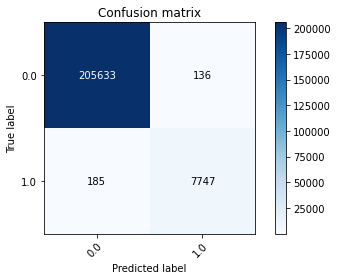

In [ ]:
y_pred = best_model.predict(dtest).round()
report(y_test, y_pred, X_test.shape[0], labels, "scaled")

**Interpretation:**

**With XGBoost, we achieved noticeably better results than Random Forest, mainly because it's much more faster, so we could reach a good trade-off between the accuracy and the computational time.** 

## CatBoost classifier

**CatBoost offers a new technique called Minimal Variance Sampling (MVS), which is a weighted sampling version of Stochastic Gradient Boosting. In this technique, the weighted sampling happens in the tree-level and not in the split-level. The observations for each boosting tree are sampled in a way that maximizes the accuracy of split scoring. So it may work well for our classification problem.**

**CatBoost has the advantage of being robust; It reduces the need for extensive hyper-parameter tuning and lower the chances of overfitting also which leads to more generalized models. Although, CatBoost has multiple parameters to tune and it contains parameters like the number of trees, learning rate, regularization, tree depth** ...

**Below, we first trained the classifier with its default parameters then we proceeded to tuning We won't be doing a full grid search here but just a local search following this order :**

1.   **First we'll optimise l2_leaf_reg independently of everything else.**
2.   **Then because iterations and learning_rate are tightly coupled, we'll grid search them together.**
3.   **Finally, we'll find the best depth**. 

**Because we didn't do a full grid search we may not have the optimal settings, but we should be pretty close.**


In [ ]:
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

from catboost import CatBoostClassifier, Pool, cv, MetricVisualizer
from sklearn.metrics import accuracy_score

     |████████████████████████████████| 64.4MB 71kB/s 
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


### **Performances with default parameters**
First, let's check the performances of this classifier on our dataset, with its default parameters.  We just fix random seed for reproductibility

In [ ]:
model = CatBoostClassifier( random_seed=42, logging_level='Silent')
model.fit(
    X_train_scale, y_train,
    eval_set=(X_test_scale, y_test),
    logging_level='Verbose', 
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.167911
0:	learn: 0.3189026	test: 0.3188260	best: 0.3188260 (0)	total: 402ms	remaining: 6m 41s
1:	learn: 0.1405636	test: 0.1405864	best: 0.1405864 (1)	total: 725ms	remaining: 6m 1s
2:	learn: 0.0605721	test: 0.0605886	best: 0.0605886 (2)	total: 1.05s	remaining: 5m 49s
3:	learn: 0.0303661	test: 0.0304010	best: 0.0304010 (3)	total: 1.38s	remaining: 5m 42s
4:	learn: 0.0191114	test: 0.0191778	best: 0.0191778 (4)	total: 1.68s	remaining: 5m 35s
5:	learn: 0.0138399	test: 0.0138855	best: 0.0138855 (5)	total: 1.97s	remaining: 5m 27s
6:	learn: 0.0115117	test: 0.0115652	best: 0.0115652 (6)	total: 2.28s	remaining: 5m 23s
7:	learn: 0.0100513	test: 0.0101216	best: 0.0101216 (7)	total: 2.6s	remaining: 5m 21s
8:	learn: 0.0088279	test: 0.0088786	best: 0.0088786 (8)	total: 2.9s	remaining: 5m 19s
9:	learn: 0.0080055	test: 0.0080593	best: 0.0080593 (9)	total: 3.22s	remaining: 5m 18s
10:	learn: 0.0074501	test: 0.0074796	best: 0.0074796 (10)	total: 3.52s	remaining: 5m 17s
11:	learn: 0.0


### Tuning over the **"L2 regularization coefficient"**

In [ ]:
model = CatBoostClassifier(
    custom_loss=['Accuracy'],
    random_seed=42,
    logging_level='Silent',
    loss_function='Logloss'
)

grid = { 'l2_leaf_reg': [0.1, 0.5, 1, 2, 3, 4]}

grid_search_result = model.grid_search(grid, 
                                       X=X_train_whole_scale, 
                                       y=ytrain, 
                                       cv=3,
                                       plot=True)

print("best l2_leaf_reg parameter : ", grid_search_result['params']['l2_leaf_reg'])

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 0.0039651	best: 0.0039651 (0)	total: 5m 29s	remaining: 27m 29s
1:	loss: 0.0039722	best: 0.0039651 (0)	total: 11m 1s	remaining: 22m 3s
2:	loss: 0.0039499	best: 0.0039499 (2)	total: 16m 22s	remaining: 16m 22s
3:	loss: 0.0039771	best: 0.0039499 (2)	total: 21m 37s	remaining: 10m 48s
4:	loss: 0.0040342	best: 0.0039499 (2)	total: 26m 50s	remaining: 5m 22s
5:	loss: 0.0040522	best: 0.0039499 (2)	total: 32m 2s	remaining: 0us
Estimating final quality...
best l2_leaf_reg parameter :  1


### Tuning over **"number of iterations"** and **"learning rate"**

In [ ]:
model = CatBoostClassifier(
    custom_loss=['Accuracy'],
    random_seed=42,
    logging_level='Silent',
    loss_function='Logloss',
    l2_leaf_reg=  grid_search_result['params']['l2_leaf_reg']
)

grid = {'iterations':[600, 800,1000, 1200, 1400],
          'learning_rate':[0.01,0.1,0.2,0.3]}

grid_search_result = model.grid_search(grid, 
                                       X=X_train_whole_scale, 
                                       y=ytrain, 
                                       cv=3,
                                       plot=True)

print("best parameters : ", grid_search_result['params'])

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 0.0054681	best: 0.0054681 (0)	total: 3m 10s	remaining: 1h 26s
1:	loss: 0.0036607	best: 0.0036607 (1)	total: 6m 18s	remaining: 56m 50s
2:	loss: 0.0036597	best: 0.0036597 (2)	total: 9m 25s	remaining: 53m 26s
3:	loss: 0.0037967	best: 0.0036597 (2)	total: 12m 30s	remaining: 50m
4:	loss: 0.0051438	best: 0.0036597 (2)	total: 16m 39s	remaining: 49m 57s
5:	loss: 0.0035485	best: 0.0035485 (5)	total: 20m 47s	remaining: 48m 31s
6:	loss: 0.0036597	best: 0.0035485 (5)	total: 24m 54s	remaining: 46m 15s
7:	loss: 0.0037967	best: 0.0035485 (5)	total: 28m 56s	remaining: 43m 24s
8:	loss: 0.0049059	best: 0.0035485 (5)	total: 34m 7s	remaining: 41m 42s
9:	loss: 0.0035387	best: 0.0035387 (9)	total: 39m 17s	remaining: 39m 17s
10:	loss: 0.0036597	best: 0.0035387 (9)	total: 44m 27s	remaining: 36m 22s
11:	loss: 0.0037967	best: 0.0035387 (9)	total: 49m 30s	remaining: 33m
12:	loss: 0.0047324	best: 0.0035387 (9)	total: 55m 44s	remaining: 30m
13:	loss: 0.0035133	best: 0.0035133 (13)	total: 1h 1m 59s	remaini

In [ ]:
model = CatBoostClassifier(
    custom_loss=['Accuracy'],
    random_seed=42,
    logging_level='Silent',
    loss_function='Logloss',
    l2_leaf_reg= 1,
)

grid = {'iterations':[1150, 1200, 1250],
          'learning_rate':[0.08, 0.1, 0.12, 0.14]}


grid_search_result = model.grid_search(grid, 
                                       X=X_train_whole_scale, 
                                       y=ytrain, 
                                       cv=3,
                                       plot=True)

print("best parameters : ", grid_search_result['params'])

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 0.0034831	best: 0.0034831 (0)	total: 6m 34s	remaining: 1h 12m 17s
1:	loss: 0.0035133	best: 0.0034831 (0)	total: 13m 1s	remaining: 1h 5m 7s
2:	loss: 0.0035110	best: 0.0034831 (0)	total: 19m 28s	remaining: 58m 24s
3:	loss: 0.0035721	best: 0.0034831 (0)	total: 25m 51s	remaining: 51m 43s
4:	loss: 0.0034831	best: 0.0034831 (0)	total: 32m 37s	remaining: 45m 39s
5:	loss: 0.0035133	best: 0.0034831 (0)	total: 39m 24s	remaining: 39m 24s
6:	loss: 0.0035110	best: 0.0034831 (0)	total: 46m 8s	remaining: 32m 57s
7:	loss: 0.0035721	best: 0.0034831 (0)	total: 52m 46s	remaining: 26m 23s
8:	loss: 0.0034831	best: 0.0034831 (0)	total: 59m 47s	remaining: 19m 55s
9:	loss: 0.0035133	best: 0.0034831 (0)	total: 1h 6m 49s	remaining: 13m 22s
10:	loss: 0.0035110	best: 0.0034831 (0)	total: 1h 13m 42s	remaining: 6m 42s
11:	loss: 0.0035721	best: 0.0034831 (0)	total: 1h 20m 24s	remaining: 0us
Estimating final quality...
best parameters :  {'iterations': 1150, 'learning_rate': 0.08}


### Tuning over the **"depth"**

In [ ]:
params = {'depth':[3,1,2,6,4,5,7,8,9,10]}

model = CatBoostClassifier(
    custom_loss=['Accuracy'],
    random_seed=42,
    logging_level='Silent',
    loss_function='Logloss',
    l2_leaf_reg= 1,
    iterations=1150,
    learning_rate=0.08
) 

grid =  {'depth':[1,2,3,4,5,6,7]}

grid_search_result = model.grid_search(grid, 
                                       X=X_train_whole_scale, 
                                       y=ytrain, 
                                       cv=3,
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 0.0056474	best: 0.0056474 (0)	total: 4m 22s	remaining: 26m 17s
1:	loss: 0.0045502	best: 0.0045502 (1)	total: 9m 11s	remaining: 22m 58s
2:	loss: 0.0041010	best: 0.0041010 (2)	total: 14m 27s	remaining: 19m 16s
3:	loss: 0.0038269	best: 0.0038269 (3)	total: 20m 7s	remaining: 15m 5s
4:	loss: 0.0035583	best: 0.0035583 (4)	total: 26m 11s	remaining: 10m 28s
5:	loss: 0.0034831	best: 0.0034831 (5)	total: 32m 37s	remaining: 5m 26s
6:	loss: 0.0035228	best: 0.0034831 (5)	total: 39m 28s	remaining: 0us
Estimating final quality...


In [ ]:
print("best parameters : ", grid_search_result['params'])

best parameters :  {'depth': 6}


### Training Catboost with **best parameters**

In [ ]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    custom_loss=['Accuracy'],
    random_seed=42,
    logging_level='Silent',
    loss_function='Logloss',
    l2_leaf_reg= 1,
    iterations=1150,
    learning_rate=0.08,
    depth=6
) 

model.fit(
    X_train_scale, y_train,
    logging_level='Verbose', 
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4850732	total: 432ms	remaining: 8m 16s
1:	learn: 0.3351698	total: 808ms	remaining: 7m 43s
2:	learn: 0.2050017	total: 1.17s	remaining: 7m 26s
3:	learn: 0.1259159	total: 1.53s	remaining: 7m 17s
4:	learn: 0.0818695	total: 1.9s	remaining: 7m 15s
5:	learn: 0.0557071	total: 2.26s	remaining: 7m 11s
6:	learn: 0.0403915	total: 2.62s	remaining: 7m 7s
7:	learn: 0.0306786	total: 2.99s	remaining: 7m 7s
8:	learn: 0.0241305	total: 3.33s	remaining: 7m 2s
9:	learn: 0.0197448	total: 3.67s	remaining: 6m 58s
10:	learn: 0.0170018	total: 4.02s	remaining: 6m 56s
11:	learn: 0.0147290	total: 4.36s	remaining: 6m 53s
12:	learn: 0.0132022	total: 4.72s	remaining: 6m 52s
13:	learn: 0.0117563	total: 5.09s	remaining: 6m 52s
14:	learn: 0.0110091	total: 5.44s	remaining: 6m 51s
15:	learn: 0.0102022	total: 5.77s	remaining: 6m 48s
16:	learn: 0.0096192	total: 6.14s	remaining: 6m 49s
17:	learn: 0.0091682	total: 6.49s	remaining: 6m 48s
18:	learn: 0.0086877	total: 6.86s	remaining: 6m 48s
19:	learn: 0.0083802	total


Accuracy with original data  :  0.9990032802841353

Number of mislabeled points out of a total 213701 points : 213


<Figure size 432x288 with 0 Axes>

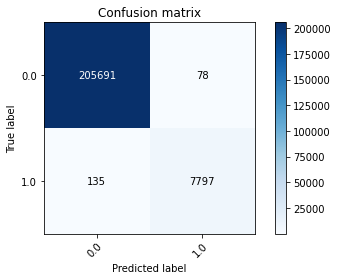

In [ ]:
y_pred = model.predict(X_test_scale)
report(y_test, y_pred, X_test.shape[0], labels)

In [ ]:
model = CatBoostClassifier(
    custom_loss=['Accuracy'],
    random_seed=42,
    logging_level='Silent',
    loss_function='Logloss',
    l2_leaf_reg= 1,
    iterations=1150,
    learning_rate=0.08,
    depth=6
) 

model.fit(
    X_train_whole_scale, ytrain,
    logging_level='Verbose', 
    plot=True
);

submission(model, X_test_whole_scale)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4837703	total: 422ms	remaining: 8m 5s
1:	learn: 0.3197041	total: 841ms	remaining: 8m 2s
2:	learn: 0.2083807	total: 1.26s	remaining: 8m 3s
3:	learn: 0.1389019	total: 1.7s	remaining: 8m 6s
4:	learn: 0.0960796	total: 2.14s	remaining: 8m 9s
5:	learn: 0.0671184	total: 2.56s	remaining: 8m 8s
6:	learn: 0.0464336	total: 3s	remaining: 8m 10s
7:	learn: 0.0343999	total: 3.42s	remaining: 8m 8s
8:	learn: 0.0283639	total: 3.87s	remaining: 8m 10s
9:	learn: 0.0226100	total: 4.28s	remaining: 8m 7s
10:	learn: 0.0185638	total: 4.69s	remaining: 8m 5s
11:	learn: 0.0160024	total: 5.09s	remaining: 8m 2s
12:	learn: 0.0138659	total: 5.49s	remaining: 8m
13:	learn: 0.0122843	total: 5.87s	remaining: 7m 56s
14:	learn: 0.0112075	total: 6.25s	remaining: 7m 53s
15:	learn: 0.0103308	total: 6.66s	remaining: 7m 51s
16:	learn: 0.0096669	total: 7.06s	remaining: 7m 50s
17:	learn: 0.0092326	total: 7.48s	remaining: 7m 50s
18:	learn: 0.0087434	total: 7.9s	remaining: 7m 50s
19:	learn: 0.0083650	total: 8.31s	remaini

submission : **0.998553474434**

**CatBoost is remarkably faster than XGBoost and gives as good results.**

## LightGBM

**LightGBM is a gradient boosting framework that is capable of handling large datasets and has faster training speed and higher efficiency,takes lower memory to run, which makes it very convenient for our case.**
**LightGBM has many hyperparameters. We'll tune the ones we think are the most crucial:** 
**we'll start by tuning learning_rate and n_estimators : The lower is the learning rate the slower is the learning from one tree to next and so a higher number of trees are needed to get a final reasonable model.**

**Then we'll tune the principal parameters for controlling tree building**








#### Tuning over **'learning_rate'** and **'n_estimators'**


**The lower is the learning rate the slower is the learning from one tree to next and so a higher number of trees are needed to get a final reasonable model.** 

In [ ]:
gbm_clf = lgbm.LGBMClassifier(objective ='binary',
                              num_leaves = 100,
                              feature_fraction = 0.64, 
                              bagging_fraction = 0.8, 
                              bagging_freq = 1,
                              boosting_type = 'gbdt',
                              metric =  'binary_logloss')

param_grid = {'n_estimators': [1000,2500,4000],
              'learning_rate' : [0.002, 0.02,0.2]}

grid = GridSearchCV(gbm_clf, param_grid=param_grid, cv=2, n_jobs=-1, verbose = 1)
start = time.time()
grid.fit(X_train_whole_scale, ytrain)
print("total time used for fitting: %s"%(time.time() - start))
gbm_clf.fit(X_train_whole_scale, ytrain)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 76.8min finished


total time used for fitting: 5407.007293224335


LGBMClassifier(bagging_fraction=0.8, bagging_freq=1, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.64,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               metric='binary_logloss', min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_leaves=100, objective='binary', random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [ ]:
results0 = pd.DataFrame(grid.cv_results_)[['rank_test_score',
                                          'mean_test_score', 
                                          'param_n_estimators',
                                          'param_learning_rate'
                                         ]]
results0.columns = ['rank test', 'score test','n_estimators','learning_rate']
results0

rank test  score test n_estimators learning_rate
0          6    0.998335         1000         0.002
1          5    0.998738         2500         0.002
2          4    0.998848         4000         0.002
3          3    0.998957         1000          0.02
4          2    0.999010         2500          0.02
5          1    0.999015         4000          0.02
6          7    0.979979         1000           0.2
7          7    0.979979         2500           0.2
8          7    0.979979         4000           0.2

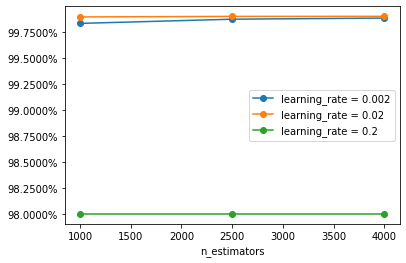

In [ ]:
df1 = results0.loc[results['learning_rate'] == 0.002]
ax=df1.plot(x='n_estimators', y='score test',style='-o', label ='learning_rate = 0.002')
df2 = results0.loc[results['learning_rate'] == 0.02]
df2.plot(x='n_estimators', y='score test',style='-o', label ='learning_rate = 0.02', ax=ax)
df3 = results0.loc[results['learning_rate'] == 0.2]
df3.plot(x='n_estimators', y='score test',style='-o', label ='learning_rate = 0.2', ax=ax)
vals = ax.get_yticks()
ax = ax.set_yticklabels(['{:,.4%}'.format(x) for x in vals])

The best results are obtained with learning rate = 0.02. we see that having 2500 and 4000 estimators give the same result at $10^{-6}$ proximity, so we'll prefer working with 2500 estimators to avoid overfitting.

The Learning rate 0.002 is too small and doesn't give the best results even with 4000 estimators. 

The Learning rate 0.2 gives the worst results, however it needs to be tested on a smaller number of estimators to see what accuracy it could reach with the right number of estimators :

In [ ]:
# Testing for LR = 0.2
gbm_clf = lgbm.LGBMClassifier(objective ='binary',
                              learning_rate = 0.2,
                              num_leaves = 100,
                              feature_fraction = 0.64, 
                              bagging_fraction = 0.8, 
                              bagging_freq = 1,
                              boosting_type = 'gbdt',
                              metric =  'binary_logloss')

param_grid = {'n_estimators': [10,20,50,100,300,600]}

grid = GridSearchCV(gbm_clf, param_grid=param_grid, cv=2, n_jobs=-1, verbose = False)
start = time.time()
grid.fit(X_train_whole_scale, ytrain)
print("total time used for fitting: %s"%(time.time() - start))
gbm_clf.fit(X_train_whole_scale, ytrain)

total time used for fitting: 162.8124713897705


LGBMClassifier(bagging_fraction=0.8, bagging_freq=1, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.64,
               importance_type='split', learning_rate=0.2, max_depth=-1,
               metric='binary_logloss', min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_leaves=100, objective='binary', random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [ ]:
results01 = pd.DataFrame(grid.cv_results_)[['rank_test_score',
                                          'mean_test_score', 
                                          'param_n_estimators'
                                         ]]
results01.columns = ['rank test', 'score test','n_estimators']
results01

rank test  score test n_estimators
0          3    0.997964           10
1          1    0.998181           20
2          2    0.998067           50
3          4    0.994669          100
4          5    0.979979          300
5          5    0.979979          600

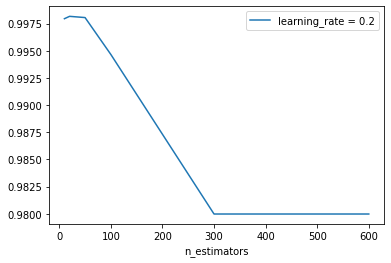

In [ ]:
results01.plot(x='n_estimators', y='score test',label='learning_rate = 0.2')

we see that even with the most adequate number of estimators for the learning rate 0.2, the accuracy is not as good as the accuracy given with learning rate = 0.02.

**Conclusion : we will use learning_rate = 0.02 and n_estimators = 2500**

### Tuning over **num_leaves**, **min_child_samples**

**An big value of the hyperparameter 'num_leaves' is likely to improve accuracy, however it can at some point cause overfitting. We'll try to find the optimal value and the corresponding best 'min_child_samples'**

In [ ]:
gbm_clf = lgbm.LGBMClassifier(objective ='binary',
                              learning_rate = 0.02,
                              n_estimators = 2500,
                              feature_fraction = 0.64, 
                              bagging_fraction = 0.8, 
                              bagging_freq = 1,
                              boosting_type = 'gbdt',
                              metric =  'binary_logloss')

param_grid = {'num_leaves': [60,80,100],
              'min_child_samples' : [10, 20,50]}

grid = GridSearchCV(gbm_clf, param_grid=param_grid, cv=2, n_jobs=-1, verbose = False)
start = time.time()
grid.fit(X_train_whole_scale, ytrain)
print("total time used for fitting: %s"%(time.time() - start))
gbm_clf.fit(X_train_whole_scale, ytrain)

In [ ]:
results1 = pd.DataFrame(grid.cv_results_)[['rank_test_score',
                                          'mean_test_score', 
                                          'param_num_leaves',
                                          'param_min_child_samples'
                                         ]]
results1.columns = ['rank test', 'score test','num_leaves', 'min_child_samples']
results1

rank test  score test num_leaves min_child_samples
0          3    0.999026         60                10
1          7    0.999020         80                10
2          5    0.999022        100                10
3          8    0.999019         60                20
4          1    0.999031         80                20
5          9    0.999010        100                20
6          2    0.999029         60                50
7          4    0.999024         80                50
8          6    0.999021        100                50

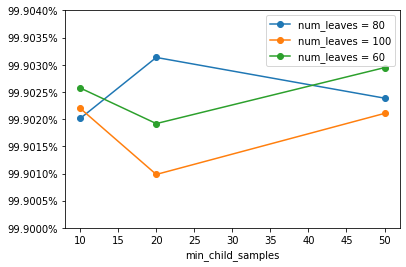

In [ ]:
df1 = results1.loc[results['num_leaves'] == 80]
ax=df1.plot(x='min_child_samples', y='score test',style='-o', ylim=(0.999,0.99904), label ='num_leaves = 80')
df2 = results1.loc[results['num_leaves'] == 100]
df2.plot(x='min_child_samples', y='score test',style='-o', label ='num_leaves = 100', ax=ax)
df3 = results1.loc[results['num_leaves'] == 60]
df3.plot(x='min_child_samples', y='score test',style='-o', label ='num_leaves = 60', ax=ax)
vals = ax.get_yticks()
ax = ax.set_yticklabels(['{:,.4%}'.format(x) for x in vals])

The best score is obtained with num_leaves = 80 and min_child_samples = 20.

We notice that for num_leaves = 60, it's possible that a better score will be reached with higher values of min_child_samples, so we'll check what it gives :

In [ ]:
gbm_clf = lgbm.LGBMClassifier(objective ='binary',
                              learning_rate = 0.02,
                              n_estimators = 2500,
                              num_leaves = 60,
                              feature_fraction = 0.64, 
                              bagging_fraction = 0.8, 
                              bagging_freq = 1,
                              boosting_type = 'gbdt',
                              metric =  'binary_logloss')

param_grid = {'min_child_samples' : [60, 80,100]}

grid = GridSearchCV(gbm_clf, param_grid=param_grid, cv=2, n_jobs=-1, verbose = True)
start = time.time()
grid.fit(X_train_whole_scale, ytrain)
print("total time used for fitting: %s"%(time.time() - start))

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 35.0min finished


total time used for fitting: 2525.016199827194


In [ ]:
results11 = pd.DataFrame(grid.cv_results_)[['rank_test_score',
                                          'mean_test_score', 
                                          'param_min_child_samples'
                                         ]]
results11.columns = ['rank test', 'score test', 'min_child_samples']
results11

rank test  score test min_child_samples
0          3    0.999023                60
1          1    0.999029                80
2          2    0.999027               100

using num_leaves = 60, we don't reach a performance as good as the optimal value we found for num_leaves = 80


### Tuning over 'max_depth'

In [ ]:
gbm_clf12 = lgbm.LGBMClassifier(objective ='binary',
                              learning_rate = 0.02,
                              n_estimators = 2500,
                              num_leaves = 80,
                              min_child_samples = 20,
                              feature_fraction = 0.64, 
                              bagging_fraction = 0.8, 
                              bagging_freq = 1,
                              boosting_type = 'gbdt',
                              metric =  'binary_logloss')

param_grid12 = {'max_depth': [6,7,8]}

grid12 = GridSearchCV(gbm_clf12, param_grid=param_grid12, cv=2, n_jobs=-1, verbose = True)
start = time.time()
grid12.fit(X_train_whole_scale, ytrain)
print("total time used for fitting: %s"%(time.time() - start))

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 32.5min finished


total time used for fitting: 2368.324167728424


In [ ]:
result12 = pd.DataFrame(grid12.cv_results_)[['rank_test_score',
                                          'mean_test_score', 
                                          'param_max_depth'
                                         ]]
result12.columns = ['rank test', 'score test', 'max_depth']
result12

rank test  score test max_depth
0          3    0.998991         6
1          1    0.999013         7
2          2    0.999009         8

Although limiting trees depth may be useful to avoid overfitting, it's clear that in our case it's not useful. 

###Tuning over 'feature_fraction' and 'bagging_fraction'

**feature_fraction is used to make LightGBM select a fraction of parameters randomly in each iteration.
bagging_fraction: specifies the fraction of data to be used for each iteration. This hyperparameter is generally used to speed up the training and avoid overfitting. This can have an influence on the performance of the algorithm.**

In [ ]:
gbm_clf2 = lgbm.LGBMClassifier(objective ='binary',
                              learning_rate = 0.02,
                              n_estimators = 2500,
                              num_leaves = 80,
                              bagging_freq = 1,
                              boosting_type = 'gbdt',
                              metric =  'binary_logloss')

param_grid2 = {'feature_fraction' : [0.64, 1],
               'bagging_fraction':[0.8, 1]}

grid2 = GridSearchCV(gbm_clf2, param_grid=param_grid2, cv=2, n_jobs=-1, verbose = True)
start = time.time()
grid2.fit(X_train_whole_scale, ytrain)
print("total time used for fitting: %s"%(time.time() - start))

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed: 54.5min finished


total time used for fitting: 3742.98730969429


In [ ]:
result2 = pd.DataFrame(grid2.cv_results_)[['rank_test_score',
                                          'mean_test_score', 
                                          'param_feature_fraction',
                                           'param_bagging_fraction'
                                         ]]
result2.columns = ['rank test', 'score test', 'feature_fraction','bagging_fraction']
result2

rank test  score test feature_fraction bagging_fraction
0          1    0.999031             0.64              0.8
1          2    0.999023                1              0.8
2          3    0.999001             0.64                1
3          4    0.998996                1                1

**we see that using fractions is better. Now we will try to find the optimal values for this fractions**

In [ ]:
gbm_clf3 = lgbm.LGBMClassifier(objective ='binary',
                              learning_rate = 0.02,
                              n_estimators = 2500,
                              num_leaves = 80,
                              bagging_freq = 1,
                              boosting_type = 'gbdt',
                              metric =  'binary_logloss')

param_grid3 = {'feature_fraction' : [0.64, 0.8,0.4],
               'bagging_fraction':[0.8, 0.6,0.4]}

grid3 = GridSearchCV(gbm_clf3, param_grid=param_grid3, cv=2, n_jobs=-1, verbose = True)
start = time.time()
grid3.fit(X_train_whole_scale, ytrain)
print("total time used for fitting: %s"%(time.time() - start))

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 101.7min finished


total time used for fitting: 6579.392857313156


In [ ]:
result3 = pd.DataFrame(grid3.cv_results_)[['rank_test_score',
                                          'mean_test_score', 
                                          'param_feature_fraction',
                                           'param_bagging_fraction'
                                         ]]
result3.columns = ['rank test', 'score test', 'feature_fraction','bagging_fraction']
result3

rank test  score test feature_fraction bagging_fraction
0          1    0.999031             0.64              0.8
1          4    0.999015              0.8              0.8
2          2    0.999027              0.4              0.8
3          3    0.999020             0.64              0.6
4          6    0.998999              0.8              0.6
5          5    0.999012              0.4              0.6
6          8    0.998960             0.64              0.4
7          9    0.998958              0.8              0.4
8          7    0.998972              0.4              0.4

### Tuning over **regularization coefficient**



In [ ]:
gbm_clf4 = lgbm.LGBMClassifier(objective ='binary',
                              learning_rate = 0.02,
                              n_estimators = 2500,
                              num_leaves = 80,
                              feature_fraction = 0.64, 
                              bagging_fraction = 0.8, 
                              bagging_freq = 1,
                              boosting_type = 'gbdt',
                              metric =  'binary_logloss')

param_grid4 = {'reg_lambda' : [0.0001, 0.001,0.1]}

grid4 = GridSearchCV(gbm_clf4, param_grid=param_grid4, cv=2, n_jobs=-1, verbose = True)
start = time.time()
grid4.fit(X_train_whole_scale, ytrain)
print("total time used for fitting: %s"%(time.time() - start))

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 37.3min finished


total time used for fitting: 2706.030697584152


In [ ]:
result4 = pd.DataFrame(grid4.cv_results_)[['rank_test_score',
                                          'mean_test_score', 
                                          'param_reg_lambda'
                                         ]]
result4.columns = ['rank test', 'score test', 'reg_lambda']
result4

rank test  score test reg_lambda
0          1    0.999025     0.0001
1          2    0.999015      0.001
2          3    0.998980        0.1

We see that adding regularization resulted in worse results, compared to what we had without regularization. 

### Tuning over **boosting type**

In [ ]:
gbm_clf5 = lgbm.LGBMClassifier(objective ='binary',
                              learning_rate = 0.02,
                              n_estimators = 2500,
                              num_leaves = 80,
                              feature_fraction = 0.64, 
                              bagging_fraction = 0.8, 
                              metric =  'binary_logloss')

param_grid5 = {'boosting_type' : ['goss', 'rf', 'dart']}

grid5 = GridSearchCV(gbm_clf5, param_grid=param_grid5, cv=2, n_jobs=-1, verbose = True)
start = time.time()
grid5.fit(X_train_whole_scale, ytrain)
print("total time used for fitting: %s"%(time.time() - start))

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 85.1min finished


total time used for fitting: 5532.300563335419


In [ ]:
result5 = pd.DataFrame(grid5.cv_results_)[['rank_test_score',
                                          'mean_test_score', 
                                          'param_boosting_type'
                                         ]]
result5.columns = ['rank test', 'score test', 'boosting_type']
result5

rank test  score test boosting_type
0          1    0.999005          goss
1          3         NaN            rf
2          2    0.998913          dart

**We see that boosting type 'goss' gives superior results compared to 'dart'.**

Remark : the grid couldn't fit the classifier with boosting_type = 'RF' as it doesn't accept parameters relative to bagging.

In [ ]:
gbm_clf = lgbm.LGBMClassifier(objective ='binary',
                              n_estimators=2500,
                              learning_rate = 0.02,
                              num_leaves = 80,
                              feature_fraction = 0.64, 
                              bagging_fraction = 0.8, 
                              min_child_samples = 25,
                              bagging_freq = 1,
                              boosting_type = 'gbdt',
                              metric =  'binary_logloss')
gbm_clf.fit(X_train_whole_scale, ytrain, eval_set=[(X_test_scale, y_test)], early_stopping_rounds=1000,  verbose=True)

[1]	valid_0's binary_logloss: 0.139874
Training until validation scores don't improve for 1000 rounds.
[2]	valid_0's binary_logloss: 0.128521
[3]	valid_0's binary_logloss: 0.120057
[4]	valid_0's binary_logloss: 0.1132
[5]	valid_0's binary_logloss: 0.10745
[6]	valid_0's binary_logloss: 0.102475
[7]	valid_0's binary_logloss: 0.0980527
[8]	valid_0's binary_logloss: 0.094068
[9]	valid_0's binary_logloss: 0.0904842
[10]	valid_0's binary_logloss: 0.0872429
[11]	valid_0's binary_logloss: 0.0842238
[12]	valid_0's binary_logloss: 0.0814342
[13]	valid_0's binary_logloss: 0.0788251
[14]	valid_0's binary_logloss: 0.0763378
[15]	valid_0's binary_logloss: 0.0739995
[16]	valid_0's binary_logloss: 0.0717927
[17]	valid_0's binary_logloss: 0.0696993
[18]	valid_0's binary_logloss: 0.0677198
[19]	valid_0's binary_logloss: 0.0658391
[20]	valid_0's binary_logloss: 0.0640383
[21]	valid_0's binary_logloss: 0.0623387
[22]	valid_0's binary_logloss: 0.0606978
[23]	valid_0's binary_logloss: 0.059134
[24]	valid_0'

LGBMClassifier(bagging_fraction=0.8, bagging_freq=1, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.64,
               importance_type='split', learning_rate=0.02, max_depth=-1,
               metric='binary_logloss', min_child_samples=25,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=2500,
               n_jobs=-1, num_leaves=80, objective='binary', random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

### Training LightGBM with the best parameters

**Let's first see the confusion matrix to observe the detailed results of our algorithm on a small test set**


Fitting time: 394.530 s

Accuracy with original data  :  0.9991343044721362

Number of mislabeled points out of a total 213701 points : 185


<Figure size 432x288 with 0 Axes>

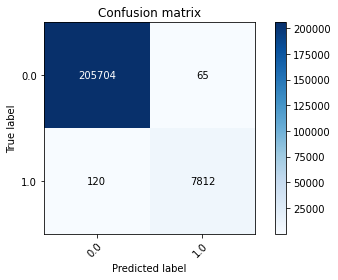

In [ ]:
gbm_clf = lgbm.LGBMClassifier(objective ='binary',
                              n_estimators=2500,
                              learning_rate = 0.02,
                              num_leaves = 80,
                              feature_fraction = 0.64, 
                              bagging_fraction = 0.8, 
                              min_child_samples = 20,
                              bagging_freq = 1,
                              boosting_type = 'gbdt',
                              metric =  'binary_logloss')
start = time.time()
gbm_clf.fit(X_train_scale, y_train)
print("\nFitting time: %0.3f s"%(time.time() - start))

y_pred = gbm_clf.predict(X_test_scale)
report(y_test, y_pred, X_test.shape[0], labels)

**We see that lightGBM gave the best accuracy so far, also the number of False positives is remarkably reduced.**

In [ ]:
gbm_clf = lgbm.LGBMClassifier(objective ='binary',
                              n_estimators=2500,
                              learning_rate = 0.02,
                              num_leaves = 80,
                              feature_fraction = 0.64, 
                              bagging_fraction = 0.8, 
                              min_child_samples = 20,
                              bagging_freq = 1,
                              boosting_type = 'gbdt',
                              metric =  'binary_logloss')
gbm_clf.fit(X_train_whole_scale, ytrain)

LGBMClassifier(bagging_fraction=0.8, bagging_freq=1, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.64,
               importance_type='split', learning_rate=0.02, max_depth=-1,
               metric='binary_logloss', min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=2500,
               n_jobs=-1, num_leaves=80, objective='binary', random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [ ]:
submission(gbm_clf, X_test_whole_scale)

Submission score : **0.998647498596**

**Thanks to the speed of lightGBM, we could fit an important number of estimators, and reach convergence in a reasonable computational time. This is not surprising as lightGBM is specifically made to perform well on large datasets.**
**It is a risky choice to not use regularization and to not limit trees depth, however we chose to follow the results given by gridsearch, which led us to prefer another parameter for avoiding overfitting which is bagging_fraction** 

# Voting between best classifiers

###LinearSVC, LogisticRegression, Random Forest

----------------------------------  Voting Classifier  ----------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



Fitting time: 757.353 s

Accuracy with scaled data  :  0.9980673932269853

Number of mislabeled points out of a total 213701 points : 413


<Figure size 432x288 with 0 Axes>

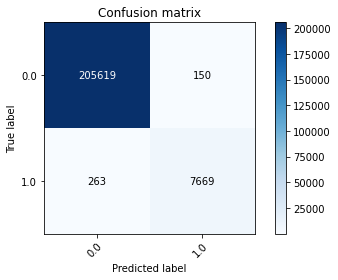

In [ ]:
print("---------------------------------- \033[1m Voting Classifier \033[0;0m ----------------------------------")

lsvm_clf = LinearSVC(C=0.1, loss="hinge")
log_clf = LogisticRegression()
RF_clf = RandomForestClassifier(criterion="gini",  max_features ='sqrt', max_depth=15)

voting_clf = VotingClassifier( estimators=[('lr', log_clf), ('svc', lsvm_clf), ('rf', RF_clf)], voting='hard')
start = time.time()
voting_clf.fit(X_train_scale, y_train)
print("\nFitting time: %0.3f s"%(time.time() - start))

y_pred = voting_clf.predict(X_test_scale)
report(y_test, y_pred, X_test.shape[0], labels, "scaled")

###LogisticRegression with 2 gradient boosting algorithms :Lightgbm, XGBoost

----------------------------------  Voting Classifier  ----------------------------------

Fitting time: 1257.039 s

Accuracy with scaled data  :  0.9987646290845621

Number of mislabeled points out of a total 213701 points : 264


<Figure size 432x288 with 0 Axes>

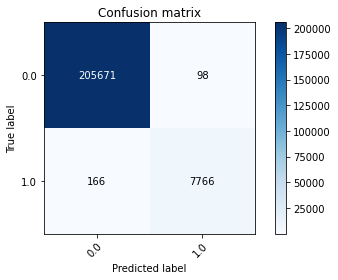

In [ ]:
print("---------------------------------- \033[1m Voting Classifier \033[0;0m ----------------------------------")
lgbm_clf = lgbm.LGBMClassifier(objective ='binary',
                              learning_rate = 0.02,
                              n_estimators = 2500,
                              num_leaves = 80,
                              feature_fraction = 0.64, 
                              bagging_fraction = 0.8, 
                              boosting_type = 'gbdt',
                              metric =  'binary_logloss')
xgb_clf = XGBClassifier(
    subsample = 1.0,
    colsample_bytree =1.0, 
    eta =0.05,
    min_child_weight=5,
    objective= 'reg:squarederror',
    max_depth=11,
    eval_metric='mae'
)
log_clf = LogisticRegression()

voting_clf = VotingClassifier(estimators=[('lgbm', lgbm_clf), ('xgb', xgb_clf),('lr', log_clf)], voting='hard')
start = time.time()
voting_clf.fit(X_train_scale, y_train)
print("\nFitting time: %0.3f s"%(time.time() - start))

y_pred = voting_clf.predict(X_test_scale)
report(y_test, y_pred, X_test.shape[0], labels, "scaled")

### GradientBoosting Classifiers : XGBoost, Lightgbm, Catboost

In [ ]:
lgbm_clf = lgbm.LGBMClassifier(objective ='binary',
                              learning_rate = 0.02,
                              n_estimators = 2500,
                              num_leaves = 80,
                              feature_fraction = 0.64, 
                              bagging_fraction = 0.8, 
                              boosting_type = 'gbdt',
                              metric =  'binary_logloss')

catb_clf = CatBoostClassifier(
    custom_loss=['Accuracy'],
    random_seed=42,
    logging_level='Silent',
    loss_function='Logloss',
    l2_leaf_reg= 1,
    iterations=1200,
    learning_rate=0.1,
) 

xgb_clf = XGBClassifier(
    subsample = 1.0,
    colsample_bytree =1.0, 
    eta =0.05,
    min_child_weight=5,
    objective= 'reg:squarederror',
    max_depth=11,
    eval_metric='mae'
)

voting_clf = VotingClassifier( estimators=[('lgbm', lgbm_clf), ('xgb', xgb_clf), ('cb', catb_clf)], voting='soft')

start = time.time()
voting_clf.fit(X_train_whole_scale, ytrain)
print("\nFitting time: %0.3f s"%(time.time() - start))

submission(voting_clf, X_test_whole_scale)


Fitting time: 1648.753 s
(3318296,)
115576


submission : **0.998598678358**

# **Conclusion:**

Recapitualtive table: (Interpretation below)

$$\begin{array}{cccc}
\text{Algorithm}&\text{Accuracy}&\text{FP}&\text{FN} &\text{Total missclassified}\\
\hline
\text{Naive Bayes} & 0.9746374607512366 &5382 & 38 & 5420\\
\hline
\text{Logistic Regression} & 0.9979878428271276 & 275 & 155 & 430\\
\hline 
\text{W-Logistic Regression} & 0.9941507058928128 & 48 & 1202 & 1250\\
\hline
\text{L-SVM} & 0.9980159194388422 & 156 &268 & 424\\
\hline
\text{PCA + L-SVM} & 0.9970940706875494 & 233 & 388 & 621\\
\hline
\text{Decision Tree} & 0.9969864436759772 & 228 &  416& 644\\
\hline
\text{W-Random Forest} & 0.9960458771835415 & 783 &  62 & 845\\
\hline
\text{AdaBoost} & 0.9981282258857002  & 146 &  254 & 400\\
\hline
\text{X-GBoost} & 0.9984979012732743  & 136 &  185 & 321\\
\hline
\text{CatBoost} & 0.9990032802841353  & 78  &  135 & 213\\
\hline
\text{Lightgbm} & 0.9991343044721362  & 65 &  120 & 185\\
\end{array}$$




We are here against a quite difficult classification problem, where the available dataset is highly skewed to the point that we can get an accuracy of a more than $0.99$ with a very poor classifier. Setting the "accuracy" as the evaluation metric for this problem is a not a good choice and make the task of classification even more difficult. It could rather "mean f1 score", "precision" and to exploit PR and ROC curves but this is the instruction of the challenge.

To deal with this high skewness of data, we prefered working at Algorithm level rather than Data level. In fact, downsampling or upsampling approaches did not help because it's not a question of tranditional unbalanced data but rather extremely unbalanced data ( the minority class represents only $3.7\%$ of our dataset). So we thought that these two approaches can easily lead to overfitting and focused rather on the choice of algorithms and tuning their most important hyperparameters. We tried forcing some classifiers, when it is possible, to put much more focus on the minority class in a weighted class approach like logistic regression, Random Forest.. and each time the accuracy get worse. We explain this as being again a problem of high skewness, because it's quite equivalent to rebalancing data so the model learn to overfit the minority class.  Therefore, our work was mainly devoted to tune model with cross-validation on the original dataset with no attempt to rebalance it. And to better evaluate our methods, we tried to interpret the performances based on confusion matrix.

For the preprocessing, we just scaled our data to have $0$ mean and a standard deviation of $1$, because based on the histograms, we found out that our features highly vary in magnitude and range, so keeping them as such will slow down our calculations and can mislead the results of some algorithms such like PCA, SVM,...By the way, we found out that PCA was not of that much help in our classification problem, performances decrease noticeably even with preserving $99\%$ of variance. 

The approach we followed was to optimize a set of classifiers, the ones we thought are more likely to work well on our dataset. Following the results we've shown above in the report, we found that Naive Bayes was the least performant algorithm so far. Maybe, this can be understood by the fact that it's based on the prior probabilities of classes, which could be not that relevant for detecting the minority class.  Comes then decision trees as the second weak classifier in our case. We expected such result since decision trees are very sensitive to noise which is likely to be the case for our dataset (samples are computed from couples of images so have by construction a high risk of being noisy). Increasing the depth of the tree can give better accuracy but on the cost of high risk of overfitting. So we didn't focused that much on tuning parameters of decision trees. 

Alternatively, we turned our focus on Random Forest hoping that it could give better performances as it performs bagging on decision trees. Actually it reached better results and gave us an idea on the most important features in our data, which we think are more trustful than those figuring on top levels of the descion tree (thanks to bagging). Trying cost-sensitive Random Forest by incorporating the weights of each class wasn't successful as we mentioned above. so we couldn't go further with random Forests and decided to try boosting classifiers. Actually, we focused the most on those classifiers and particularly Gradient Boosting ones like XGBoost, CatBoost and Lightgbm. This is not a random choice, but based on the idea that these models have built-in approaches combatting class imbalance and are noticeably faster than other boosting techniques (unlike Adaboost for example which we couldn't reach its best performances due to its high computational time). 

Actually, these gradient boosting models outperformed all the previous classifiers and reached the best performances on our dataset, with Lightgbm being the best one so far. They even outperformed voting on different collections of the other classifiers that we optimized. To cut it short, gradient boosting has been the best approach to deal with our highly skewed data by constructing successive training sets based on incorrectly classified examples and reducing the residual loss.  
